In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")

In [3]:
outlier_columns = list(df.columns[:6])

In [4]:
plt.style.use("fivethirtyeight")

In [5]:
plt.rcParams["figure.figsize"] = (20, 5)

In [6]:
plt.rcParams["figure.dpi"] = 100

<Axes: title={'center': 'gyr_y'}, xlabel='[label]'>

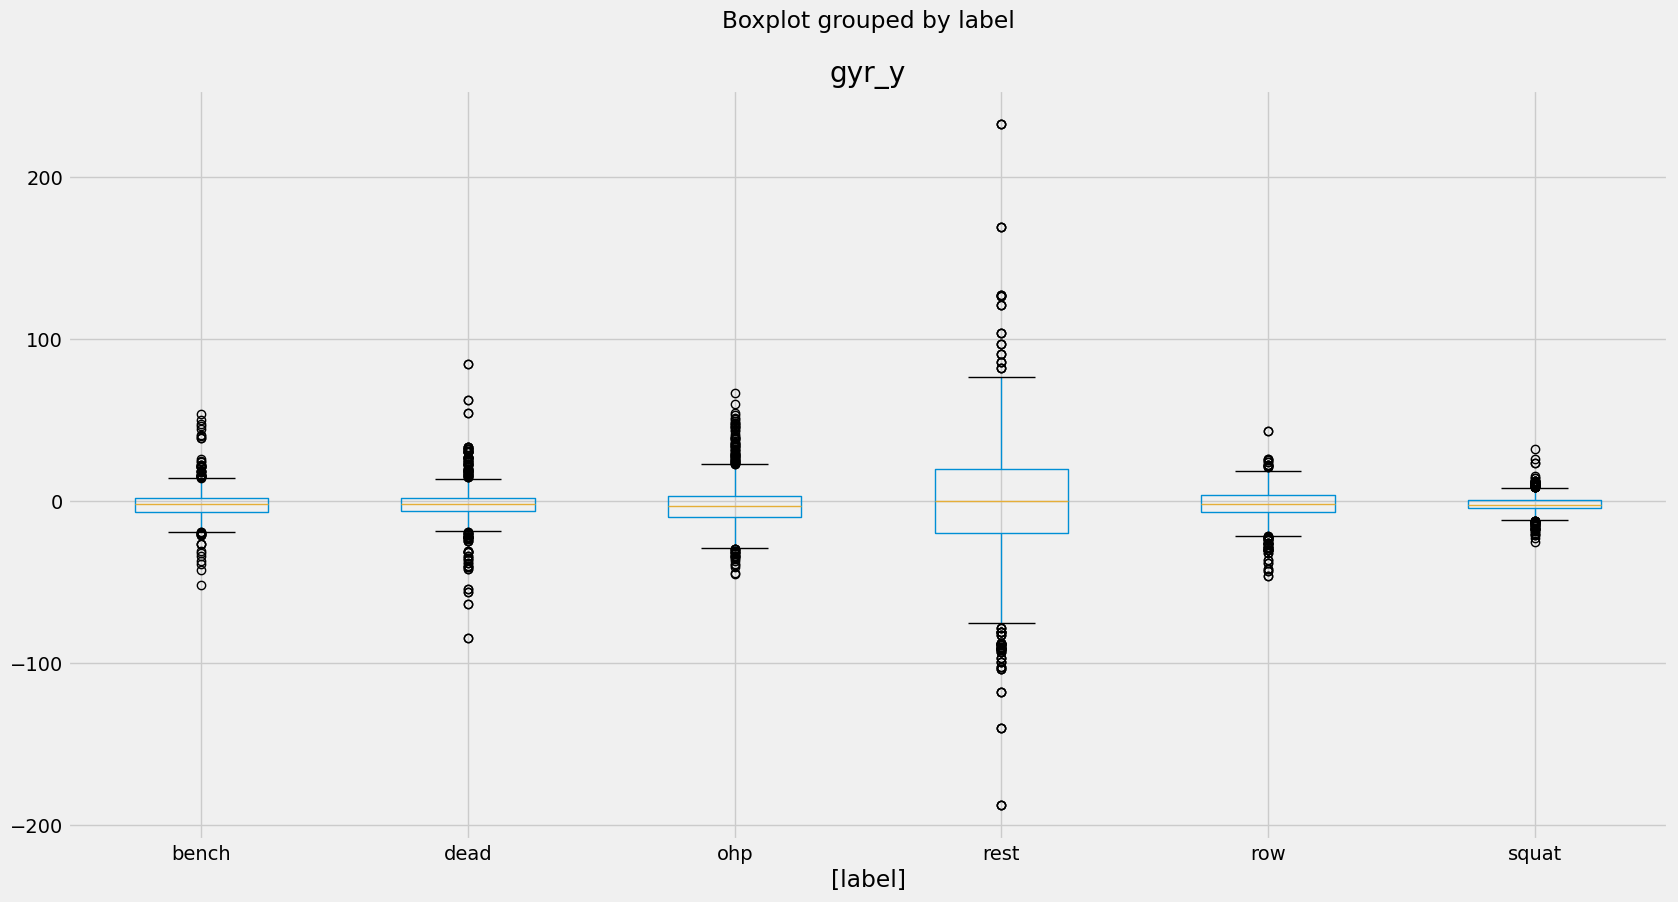

In [7]:
df[["gyr_y", "label"]].boxplot(by="label", figsize=(20,10))

array([<Axes: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_z'}, xlabel='[label]'>], dtype=object)

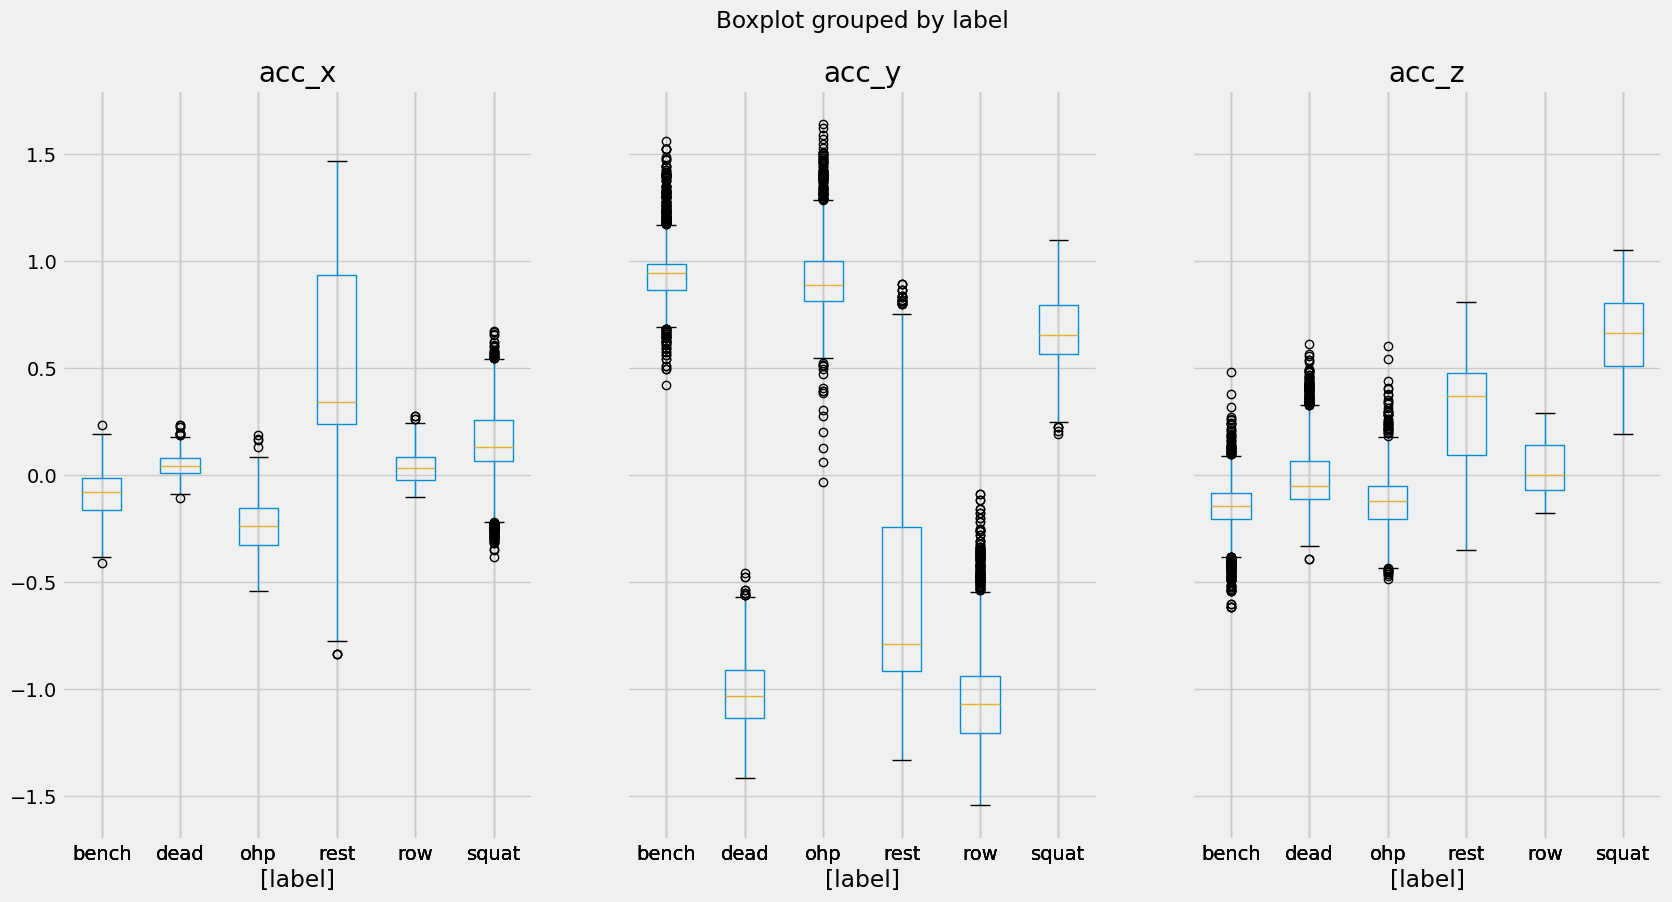

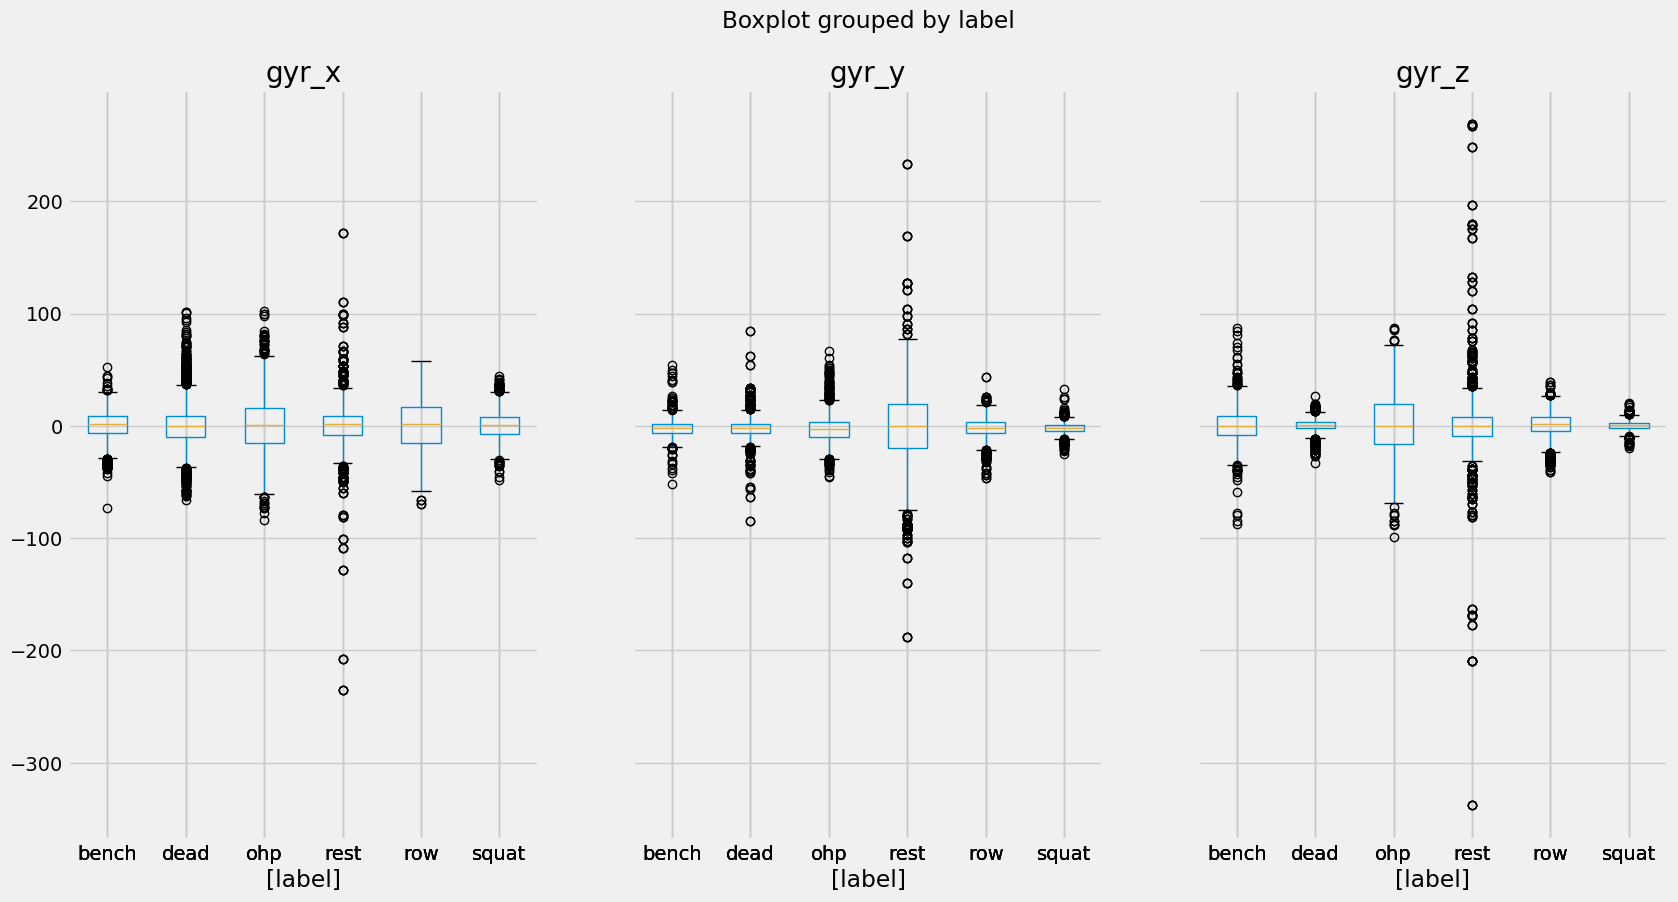

In [8]:
df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20,10), layout=(1,3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20,10), layout=(1,3))

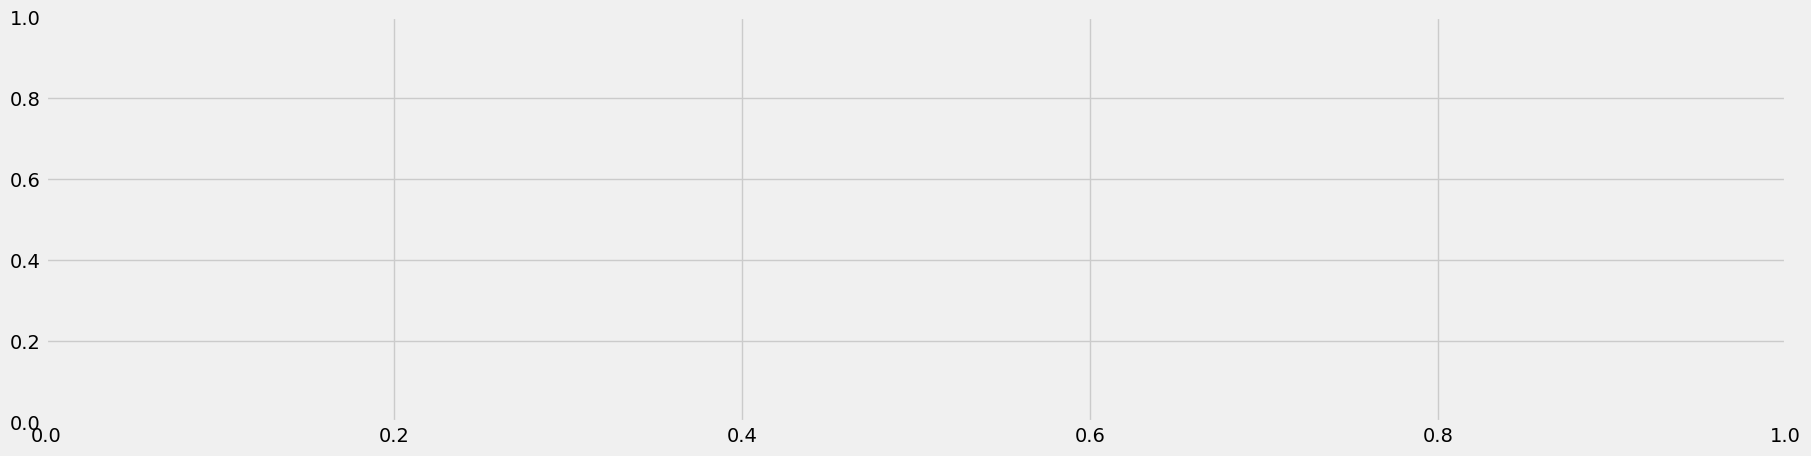

In [16]:
fig, ax = plt.subplots()

Text(0.5, 0, 'samples')

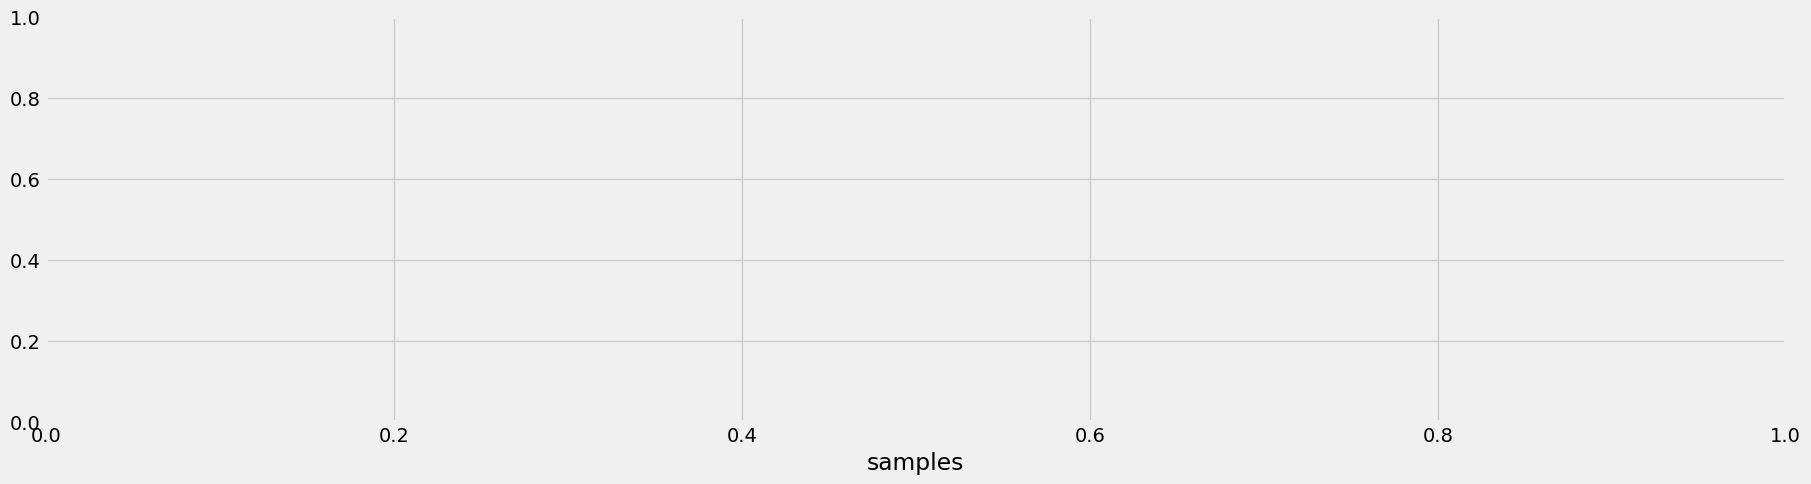

In [17]:
plt.xlabel("samples")

Text(0, 0.5, 'value')

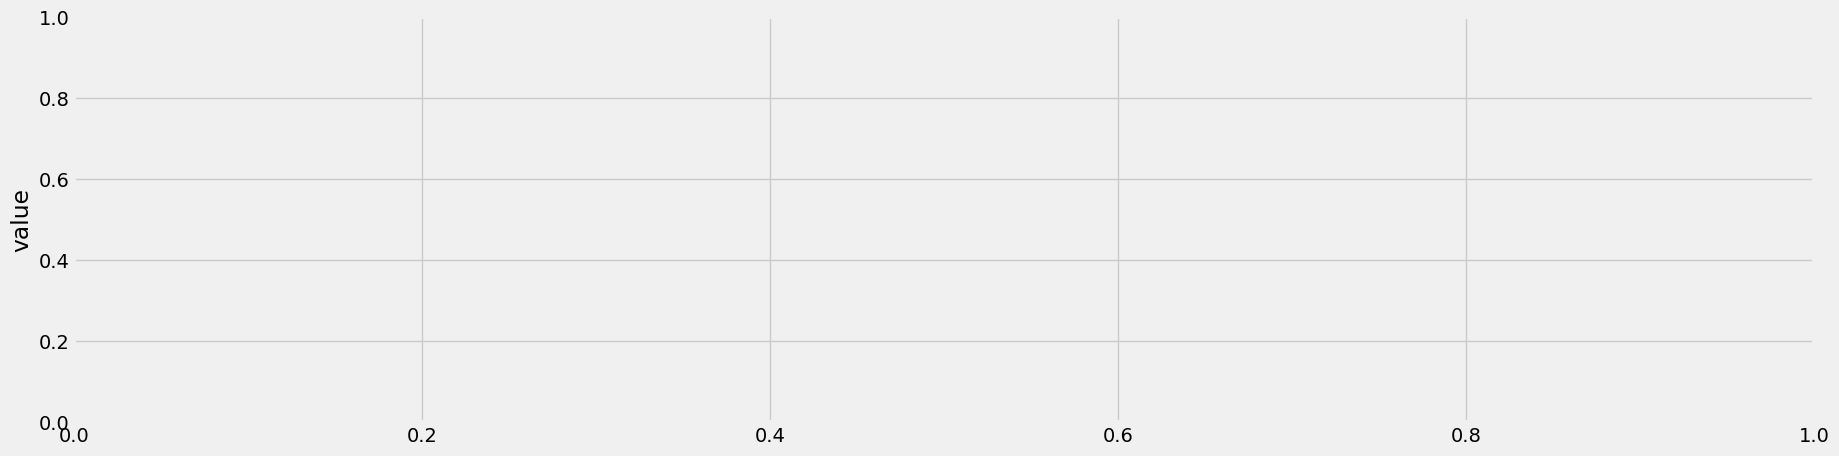

In [18]:
plt.ylabel("value")

In [26]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """
    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py
    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")
    if reset_index:
        dataset = dataset.reset_index()
    fig, ax = plt.subplots()
    plt.xlabel("samples")
    plt.ylabel("value")
    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )
    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [27]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """
    dataset = dataset.copy()
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )
    return dataset

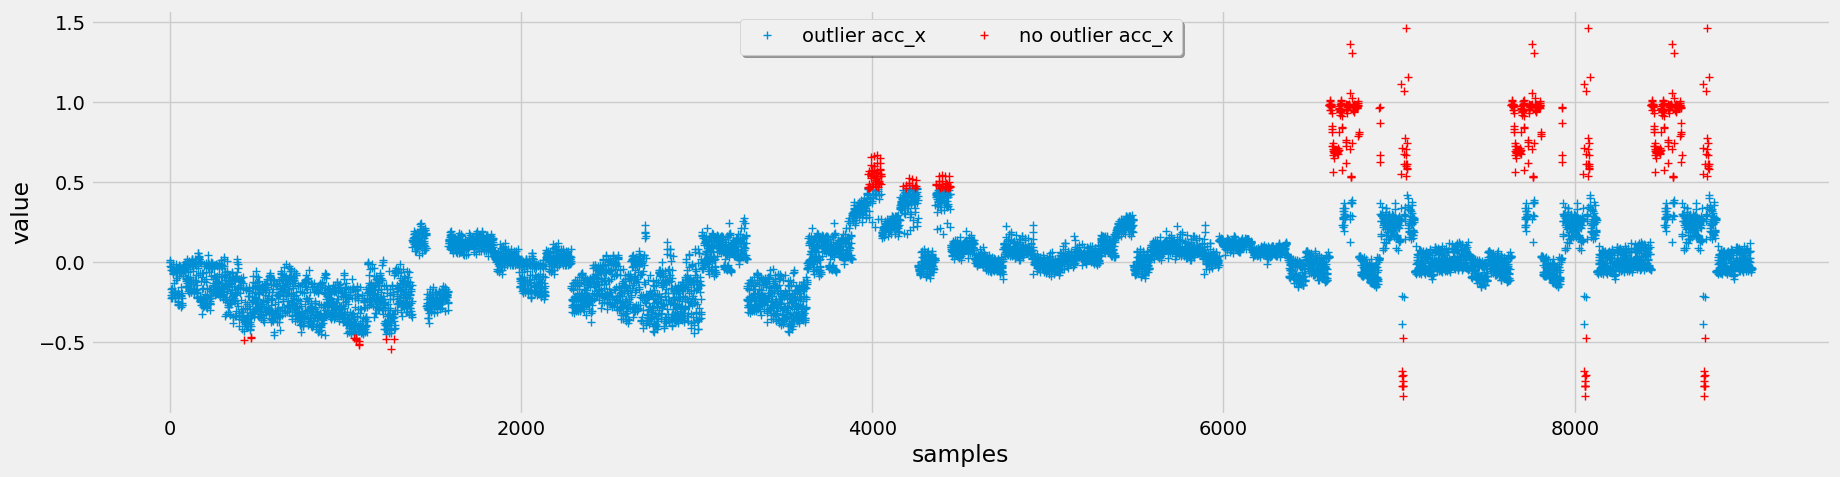

In [28]:
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

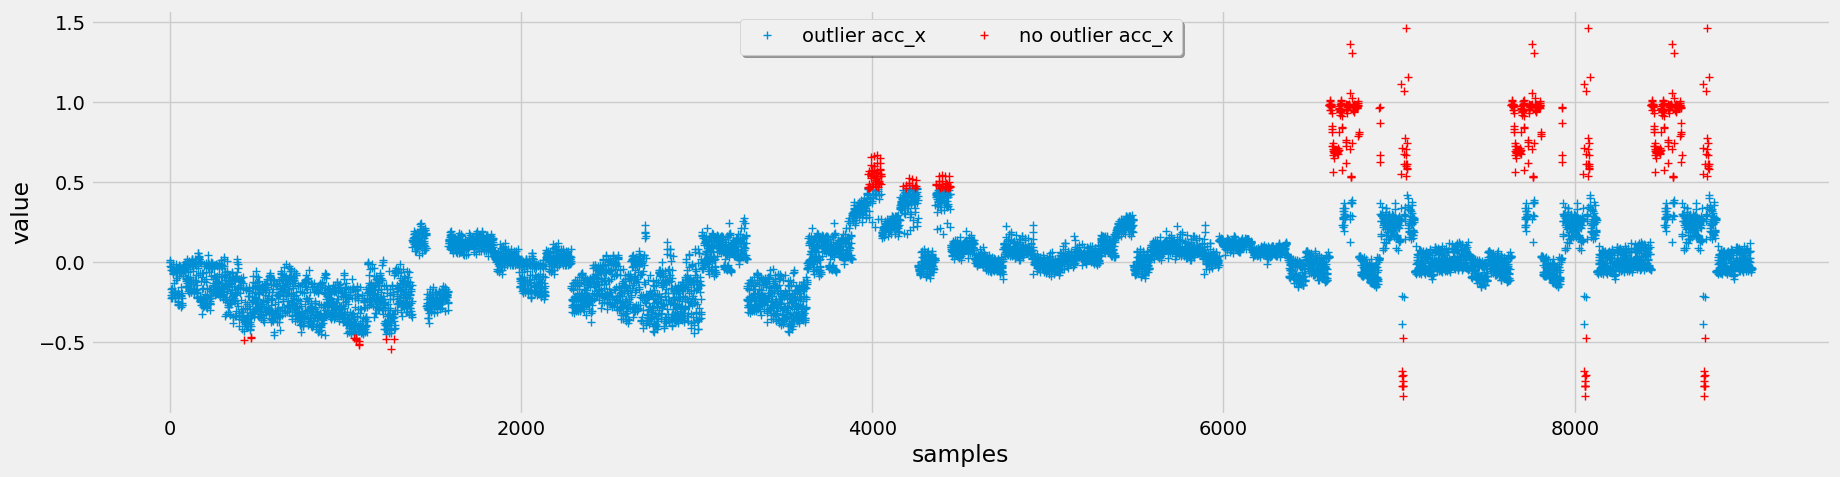

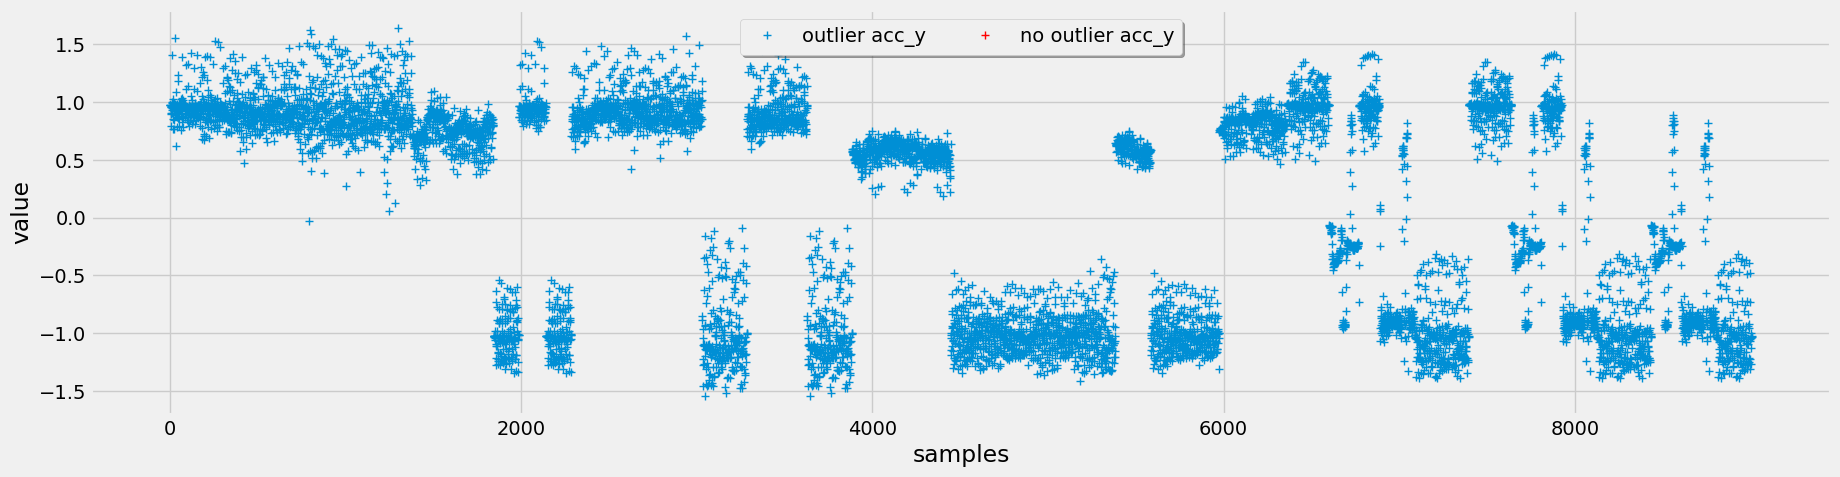

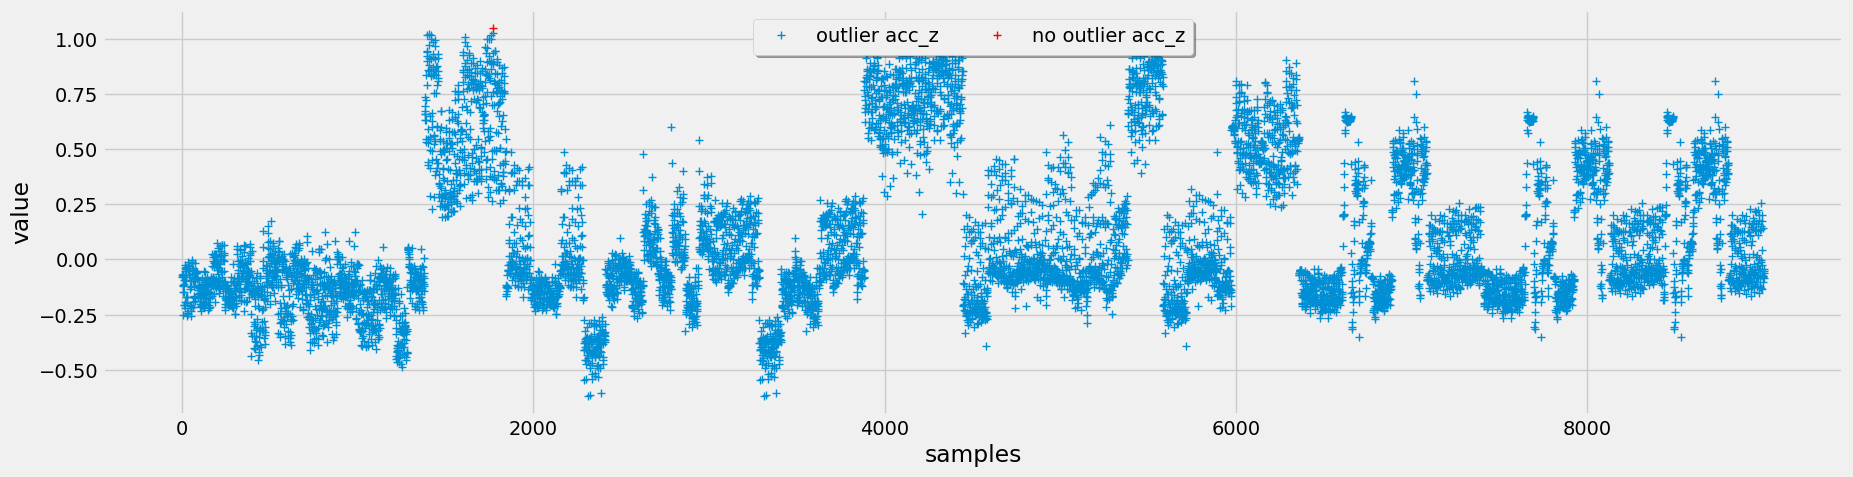

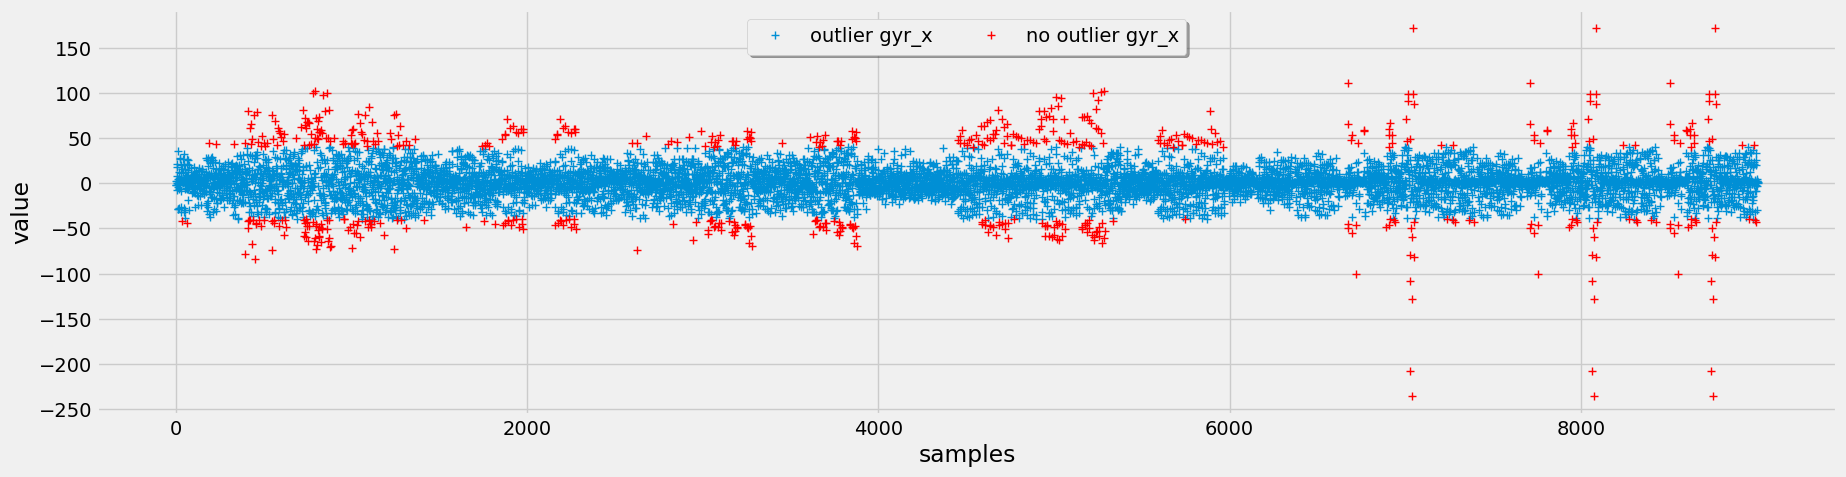

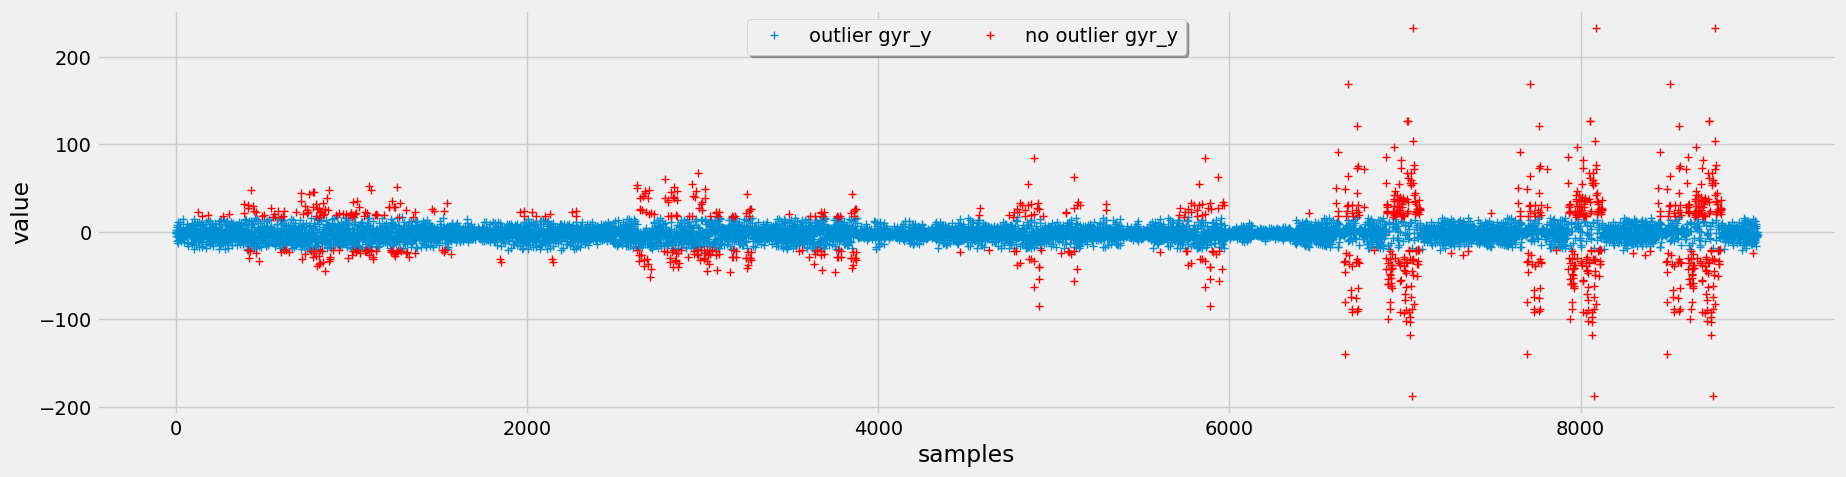

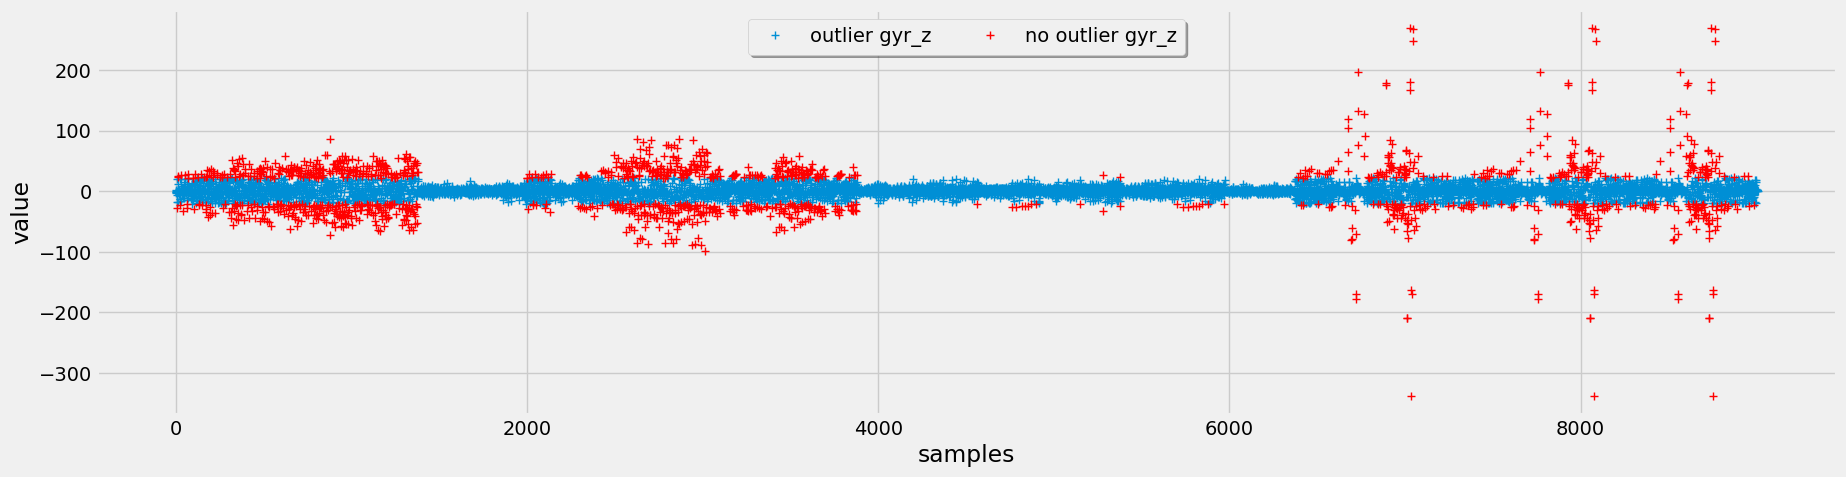

In [29]:
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

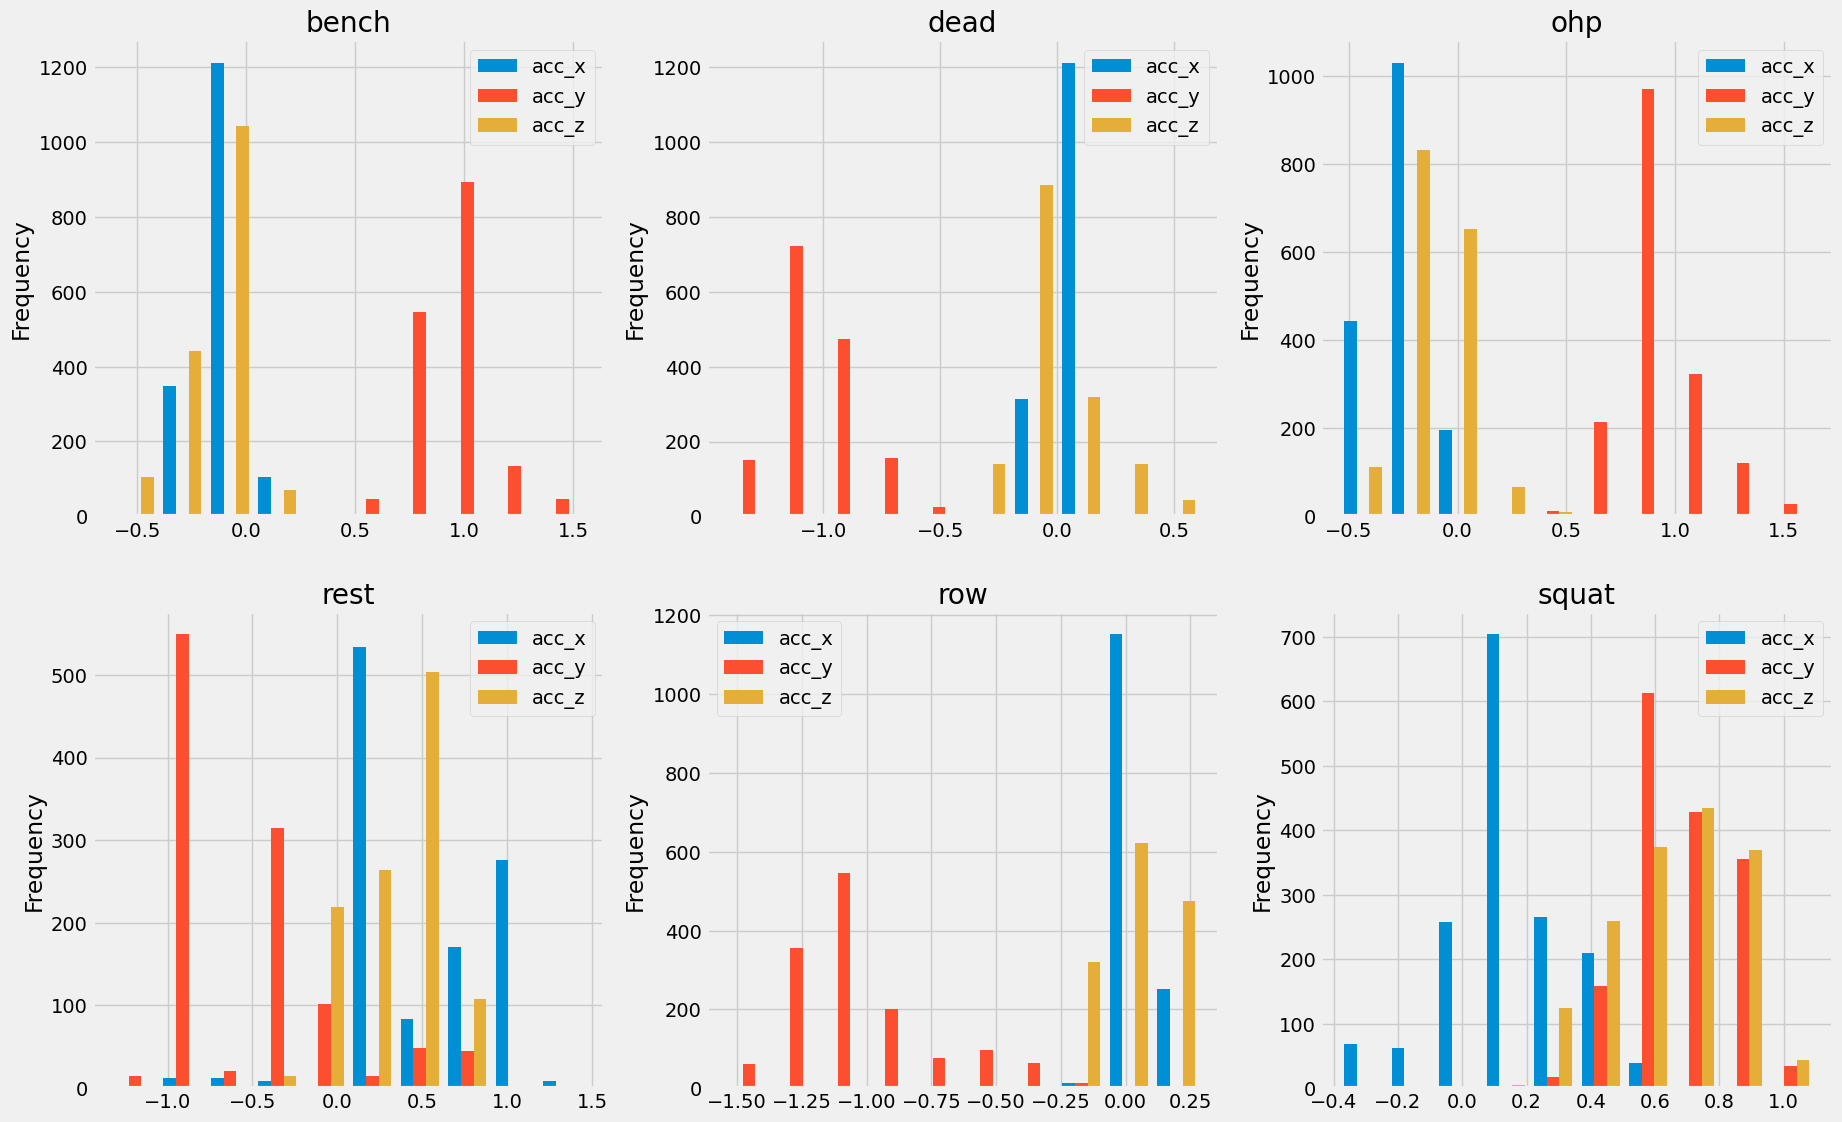

In [30]:
df[outlier_columns[:3] + ["label"]].plot.hist(by="label", figsize=(20,20), layout=(3,3))

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

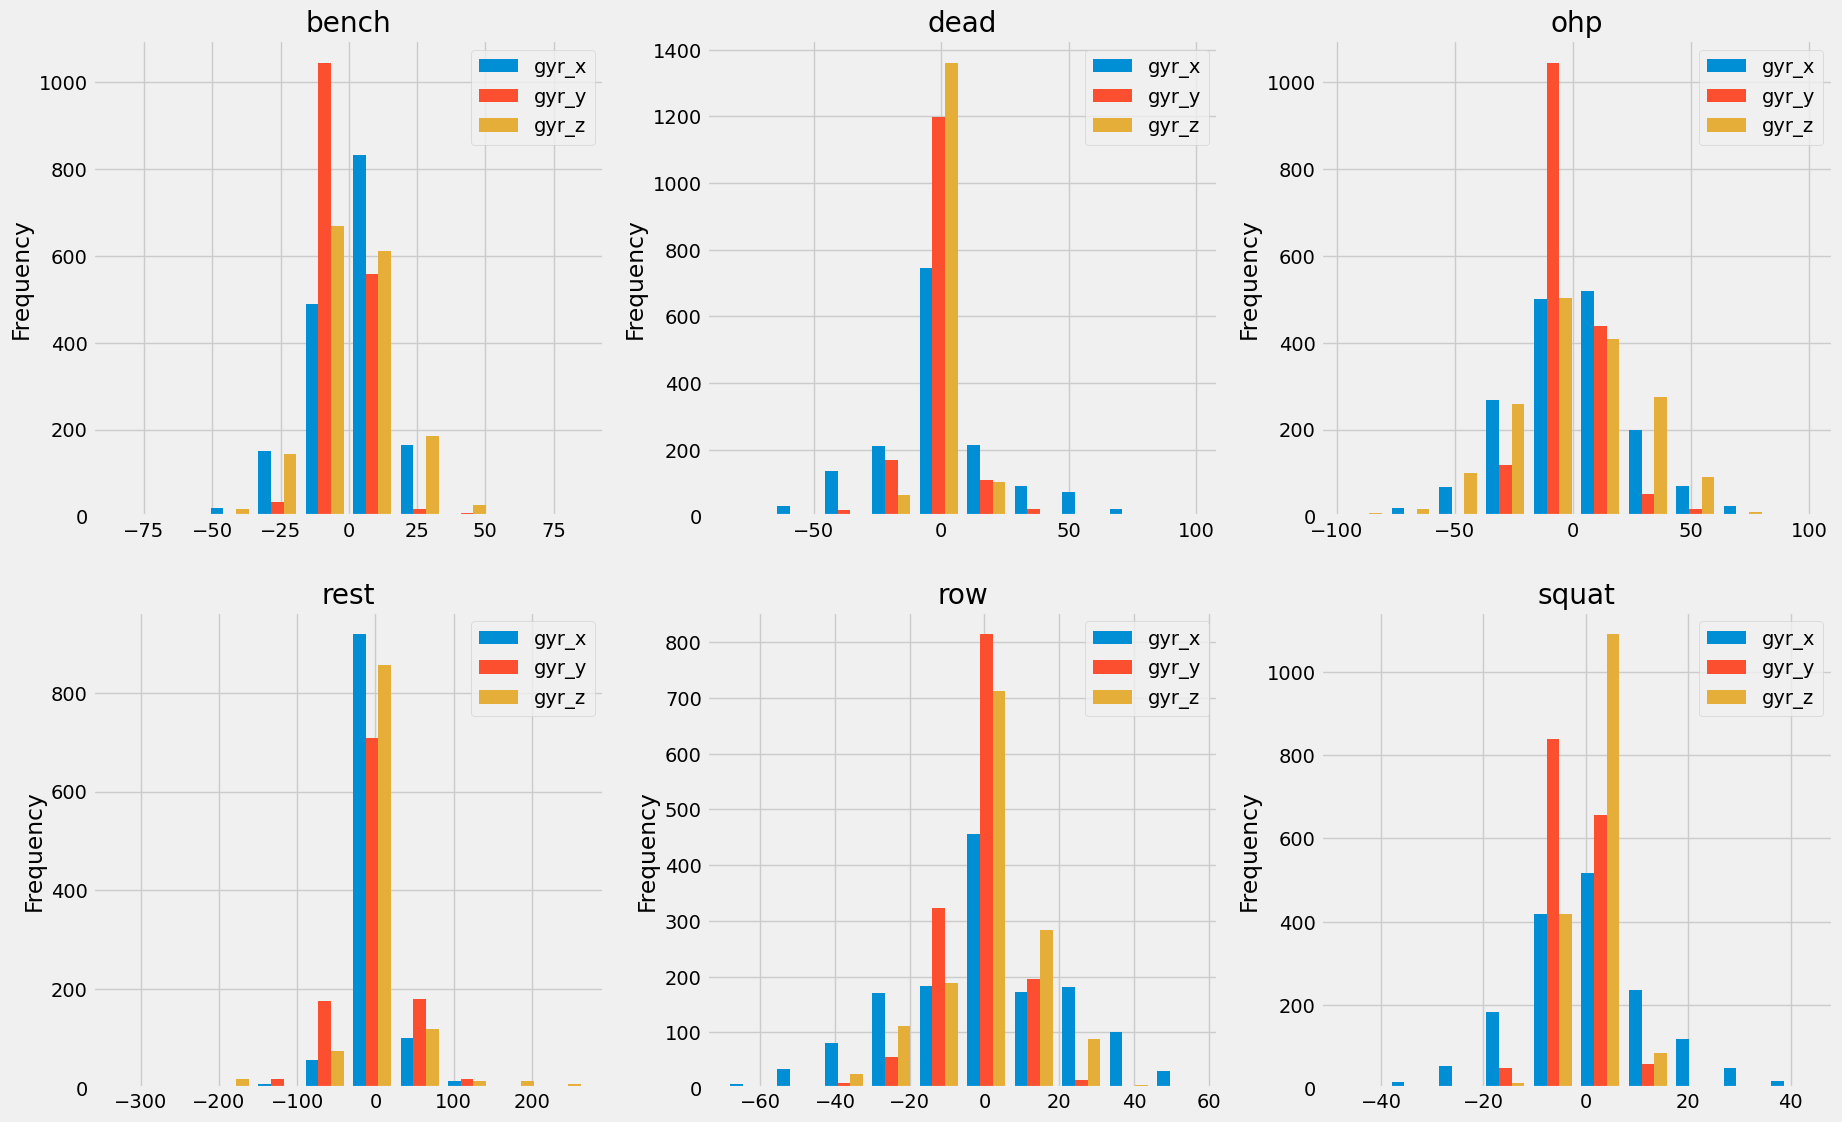

In [31]:
df[outlier_columns[3:] + ["label"]].plot.hist(by="label", figsize=(20,20), layout=(3,3))

In [32]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """
    dataset = dataset.copy()

In [34]:
mean = dataset[col].mean()

In [35]:
std = dataset[col].std()

In [36]:
N = len(dataset.index)

In [38]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

In [40]:
deviation = abs(dataset[col] - mean) / std

In [45]:
prob = []

In [46]:
mask = []

In [48]:
N = len(dataset.index)

In [49]:
std = dataset[col].std()

In [50]:
mean = dataset[col].mean()

In [51]:
dataset = dataset.copy()

In [53]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

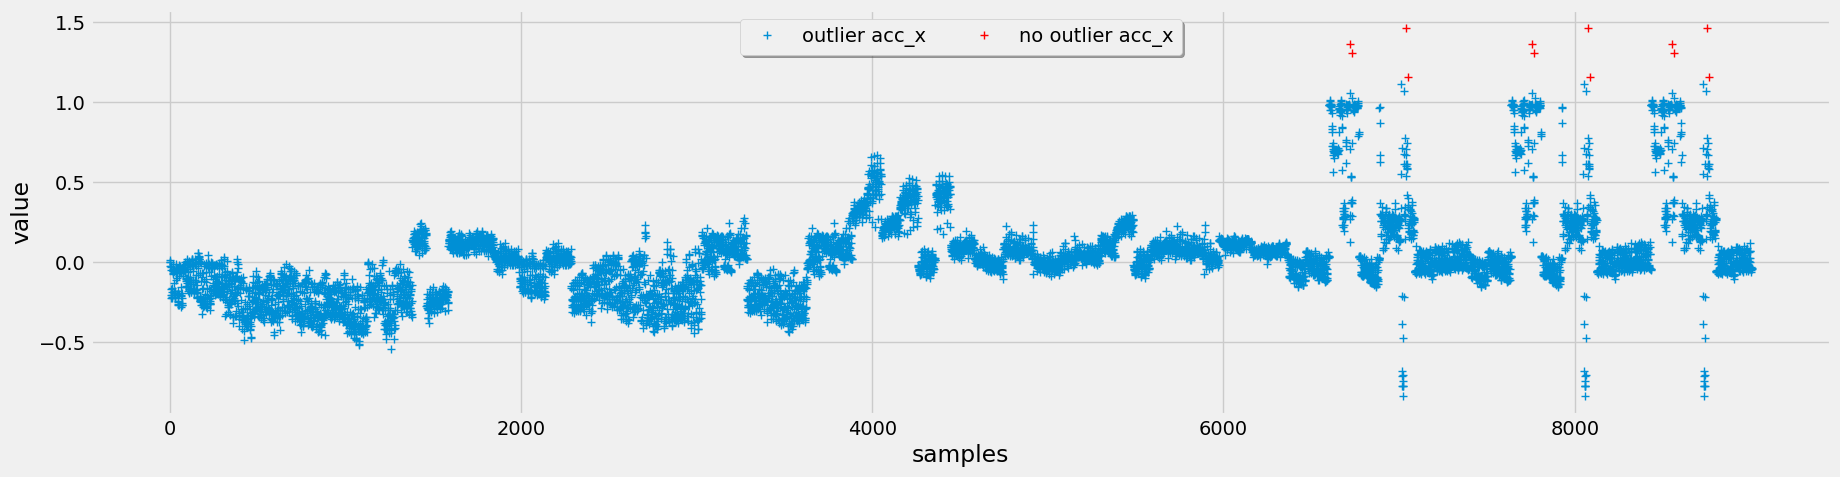

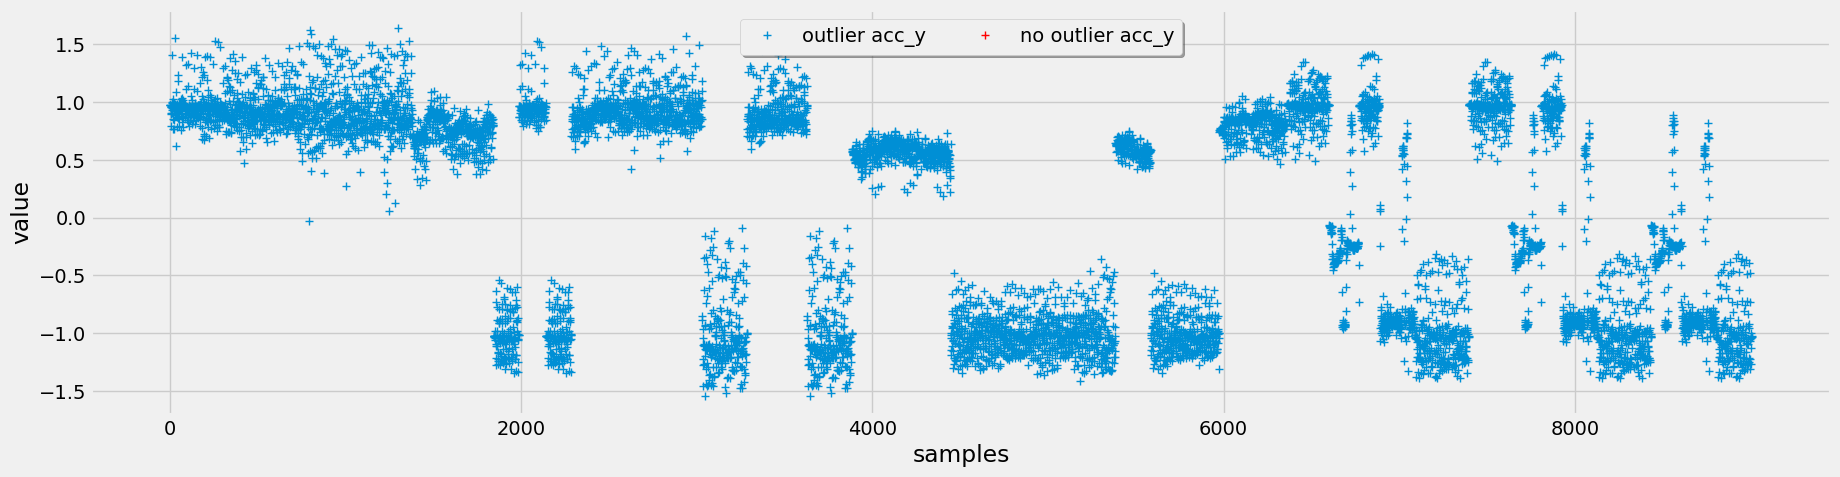

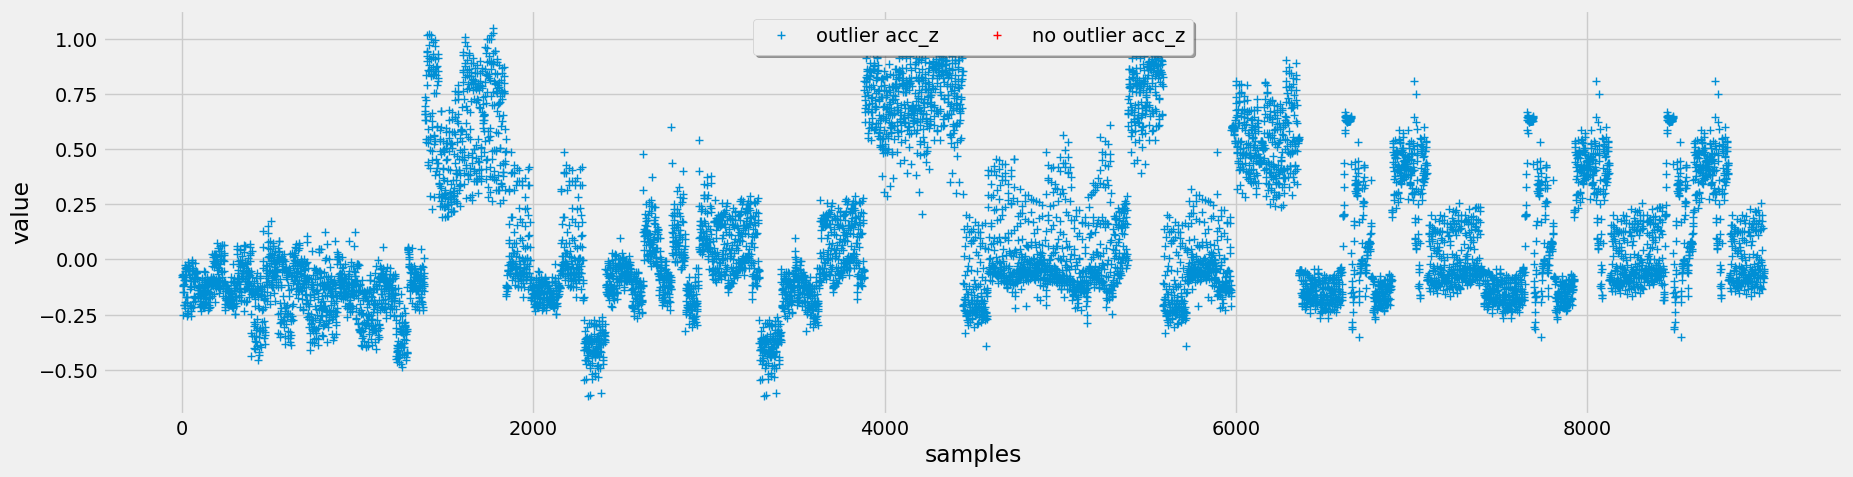

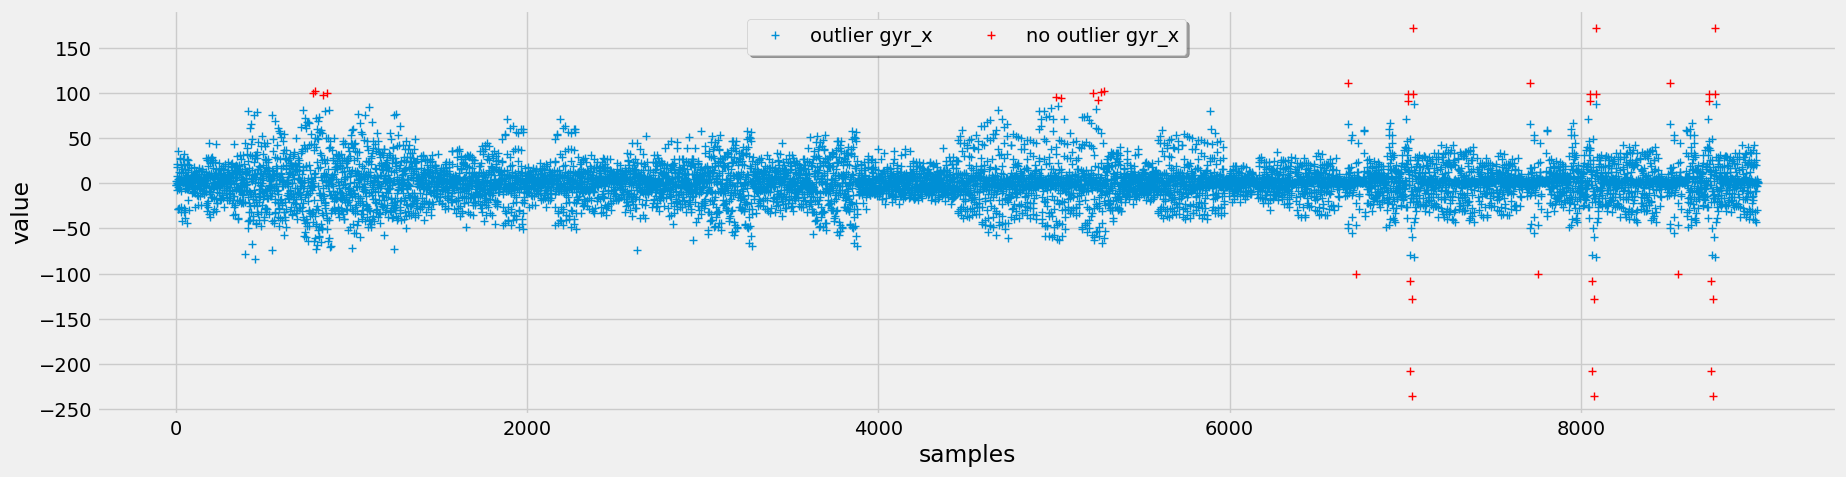

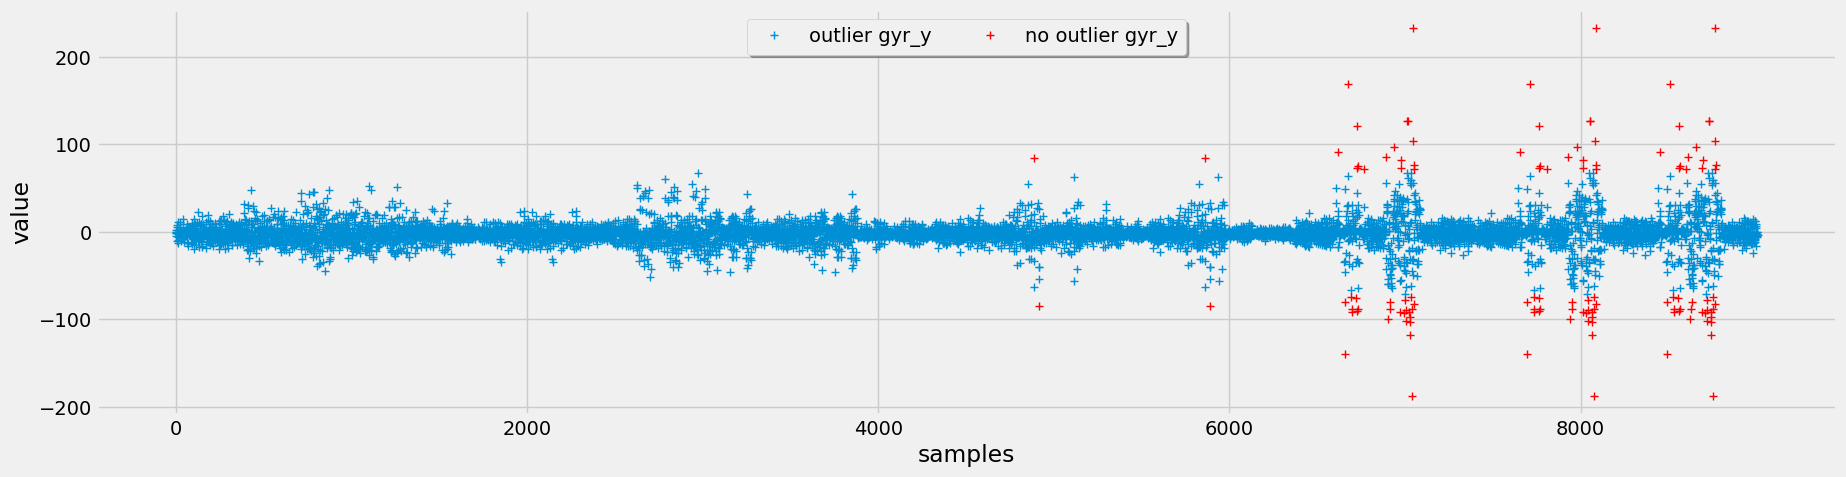

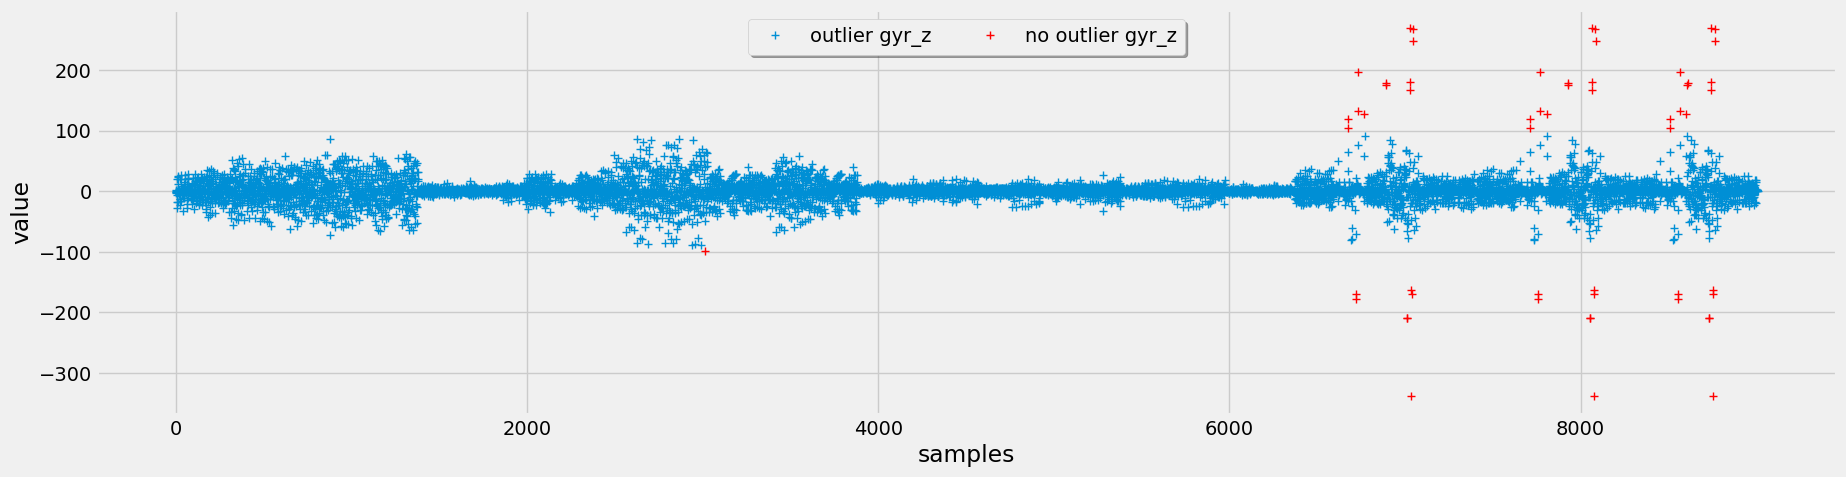

In [56]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

In [57]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF
    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    dataset = dataset.copy()
    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_
    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

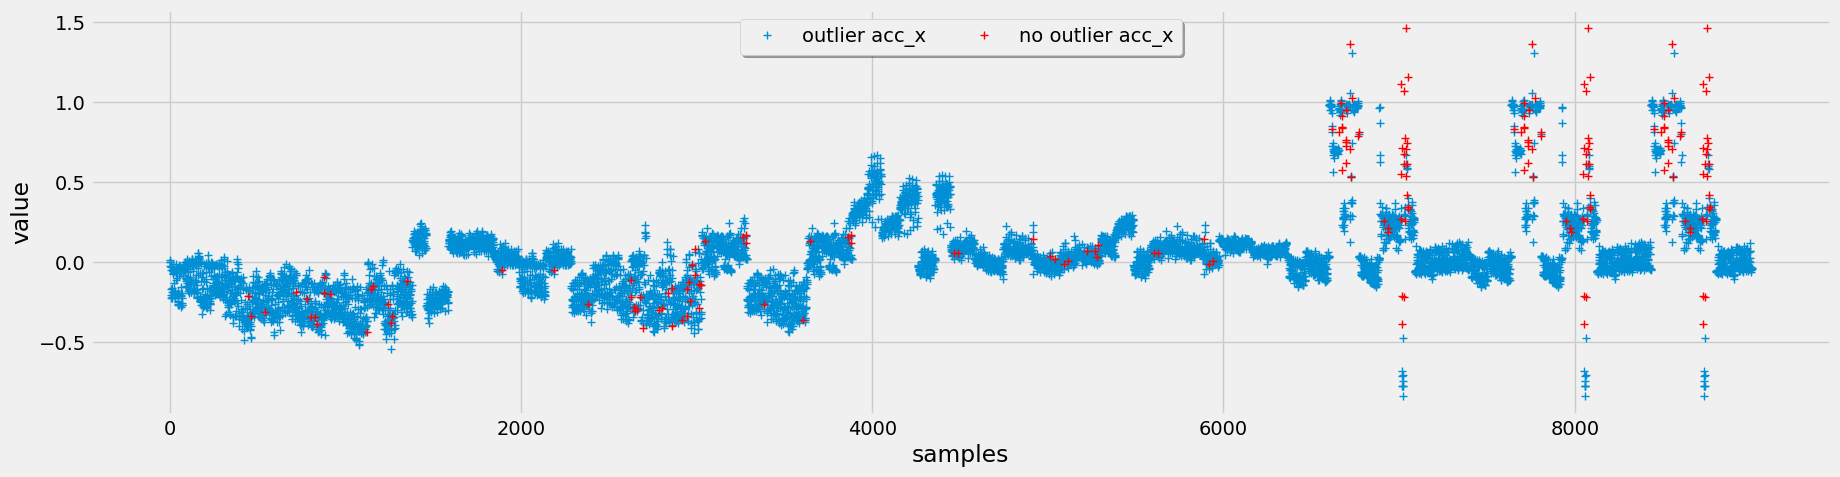

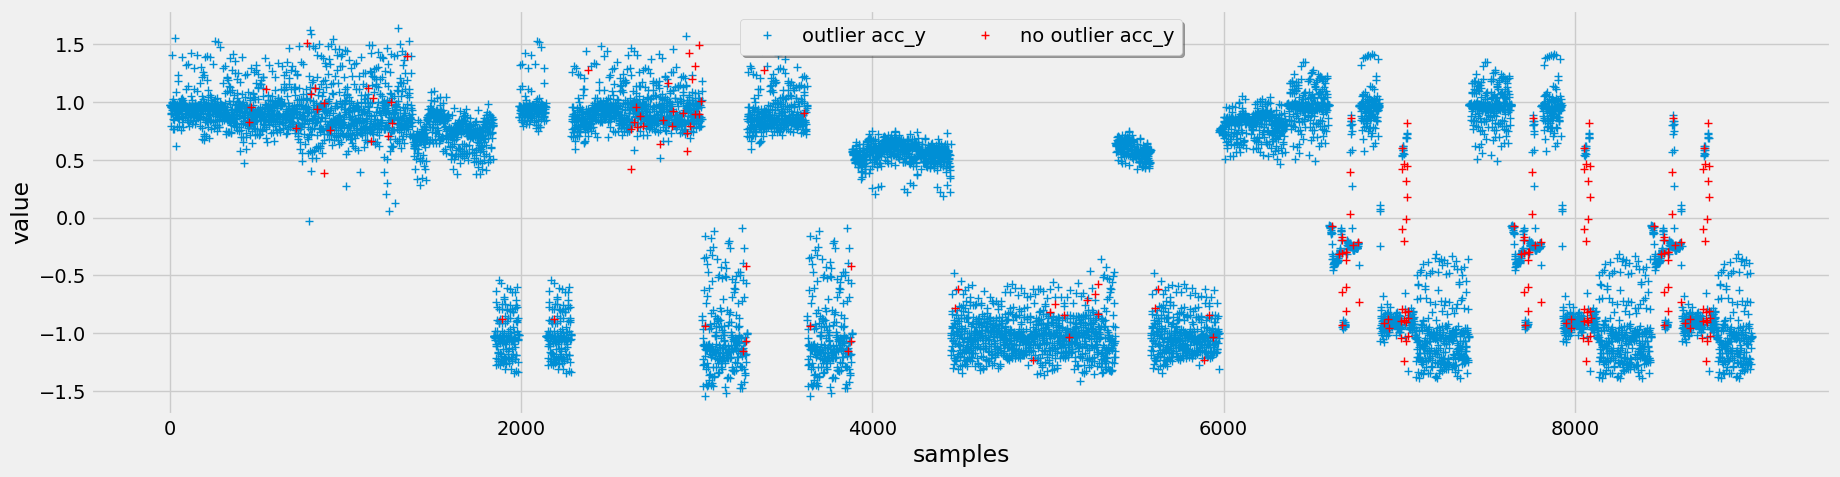

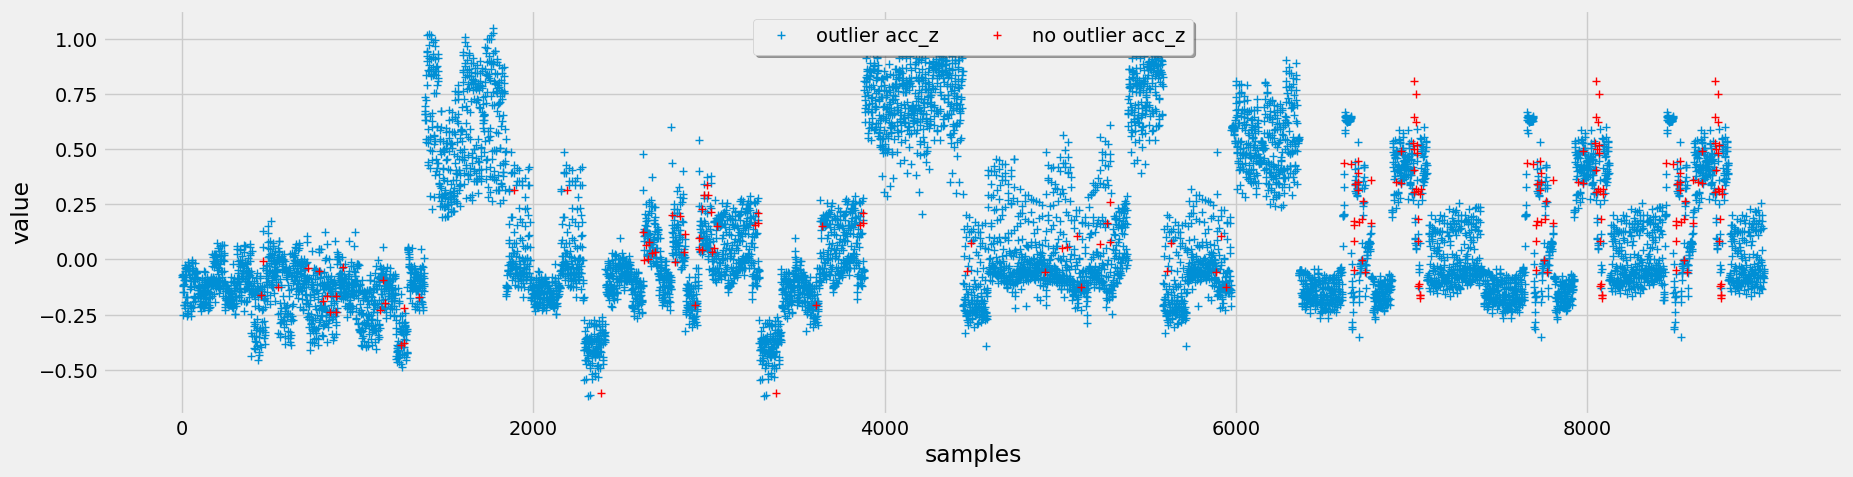

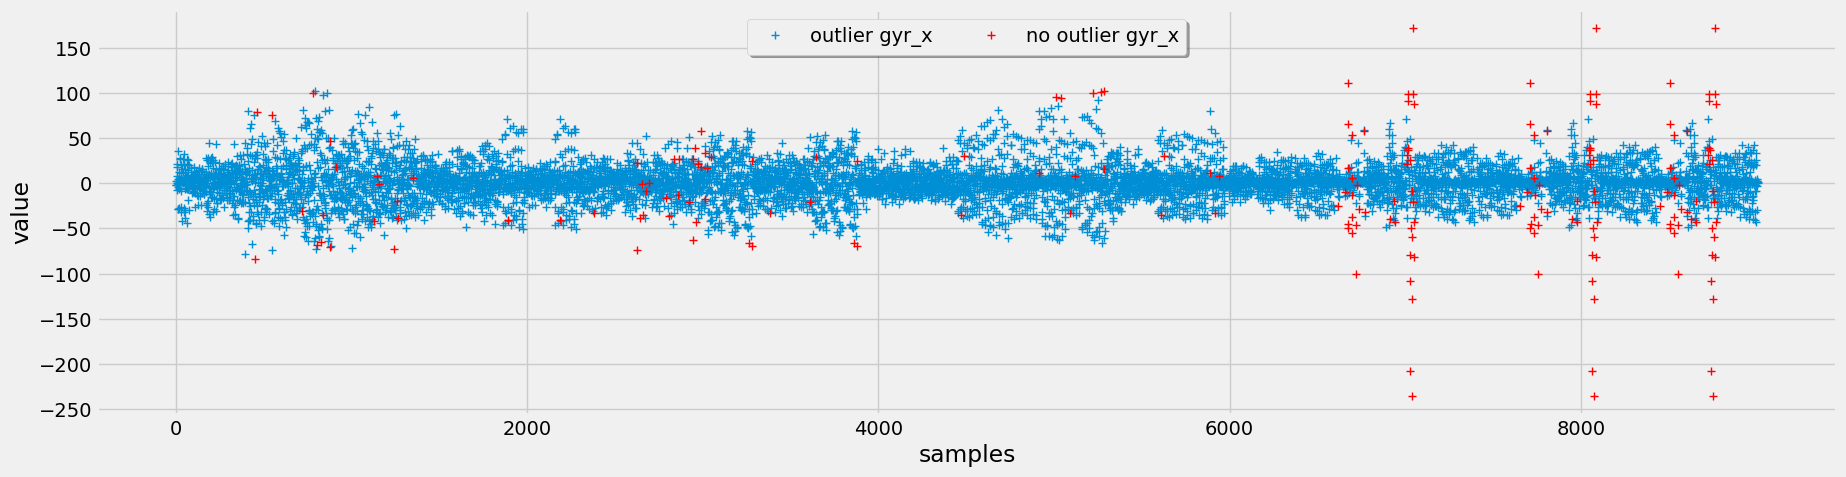

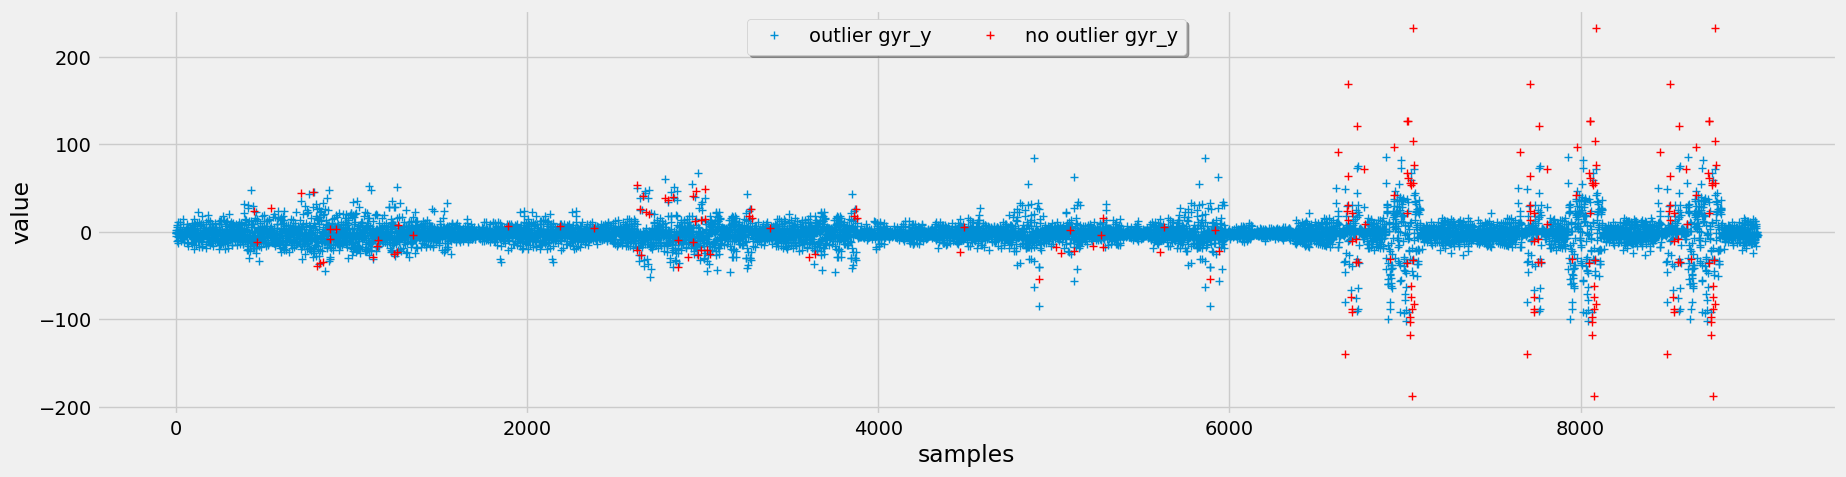

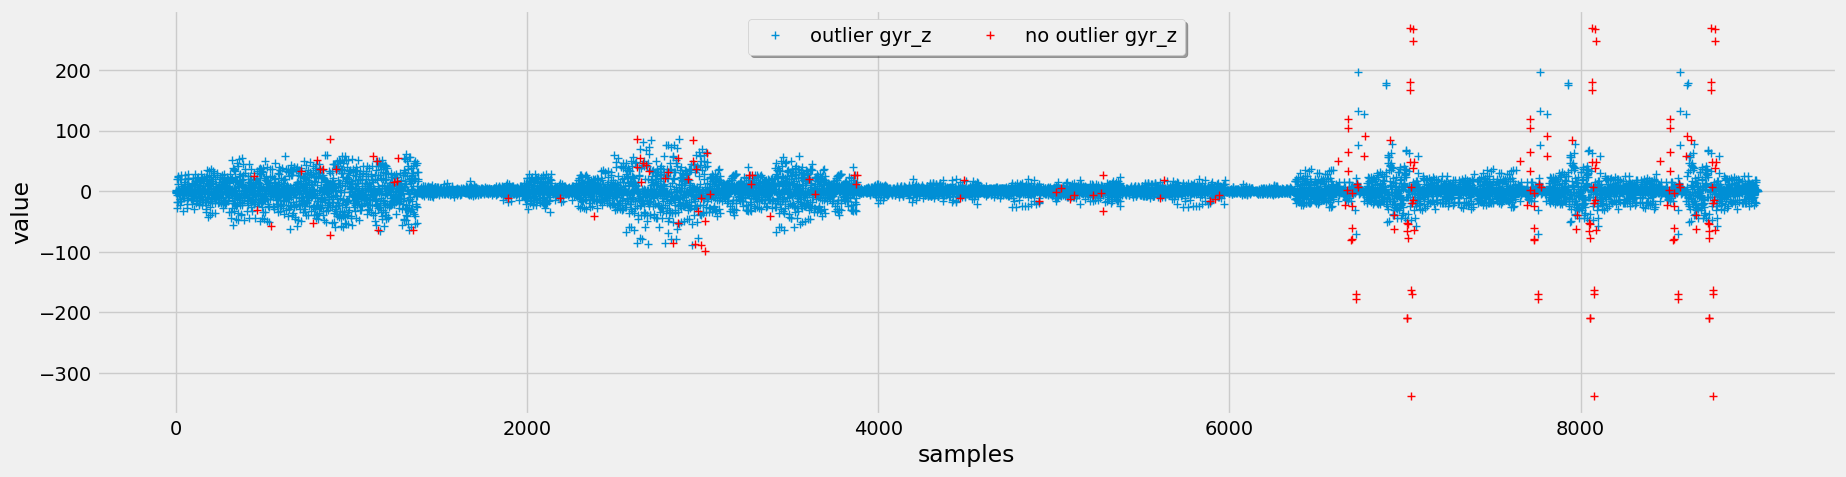

In [58]:
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True)

In [59]:
label = "bench"

In [60]:
label = "squat"

In [61]:
label = "dead"

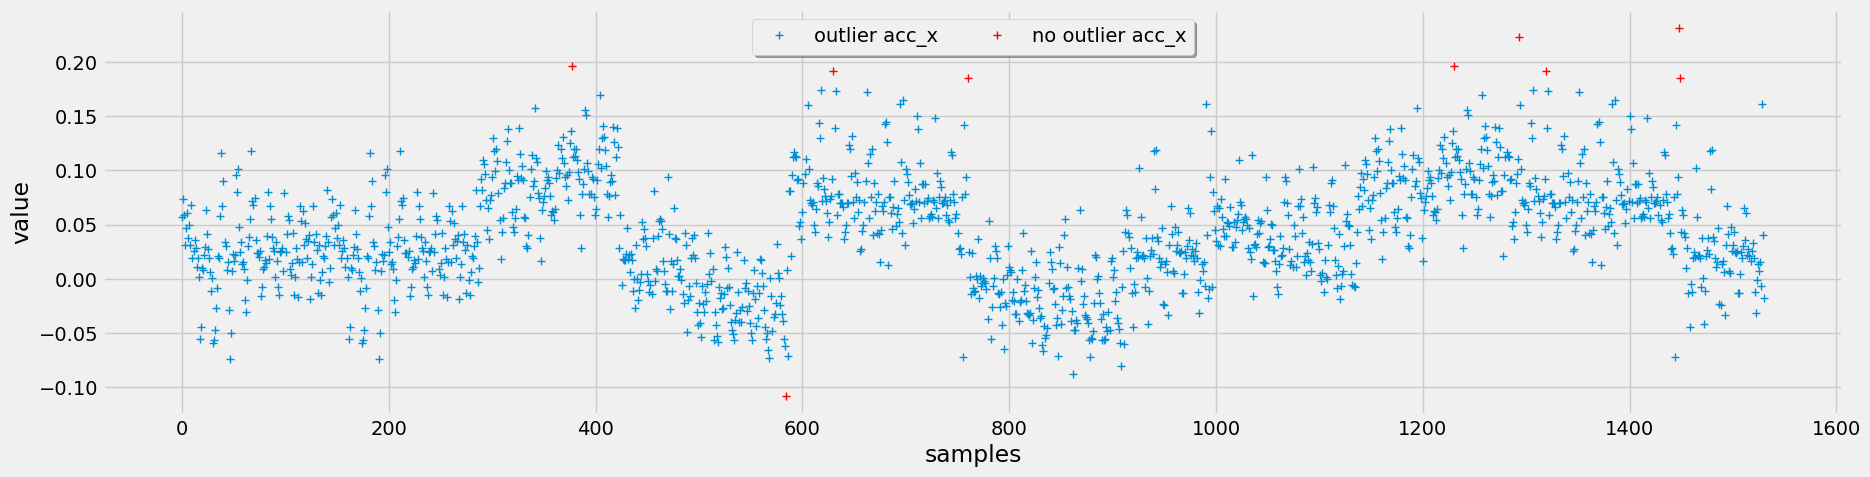

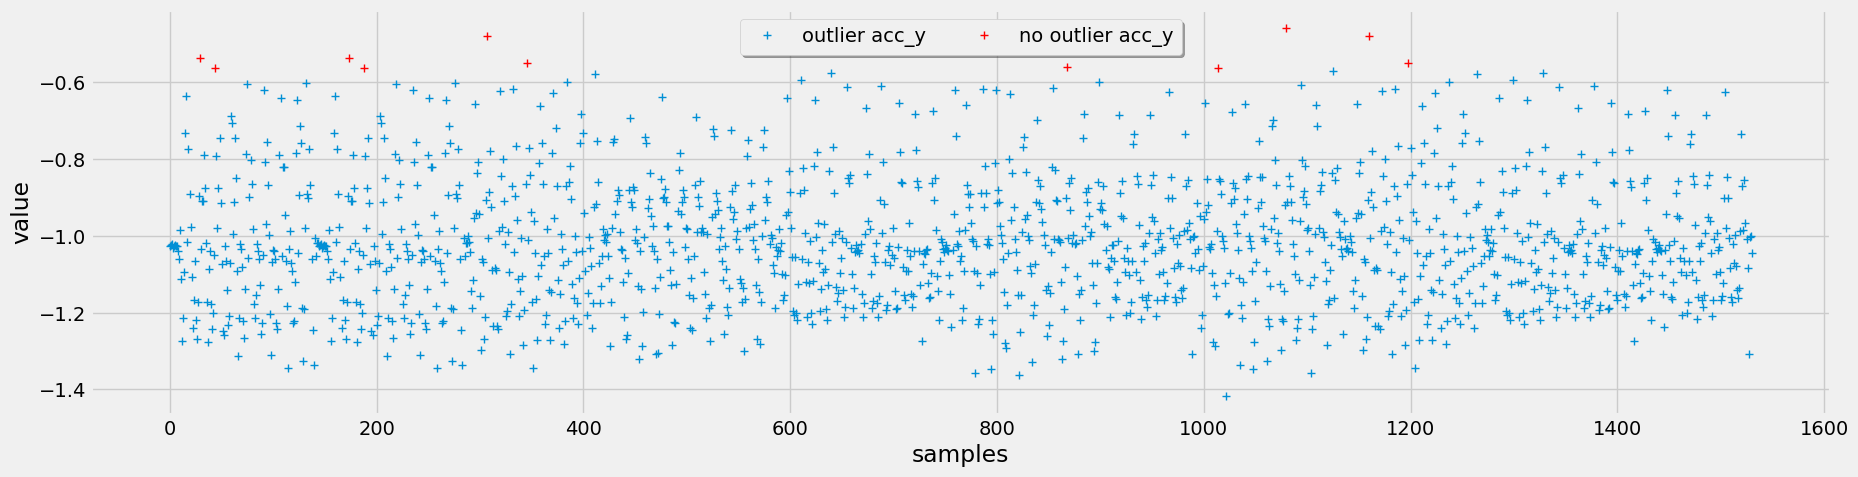

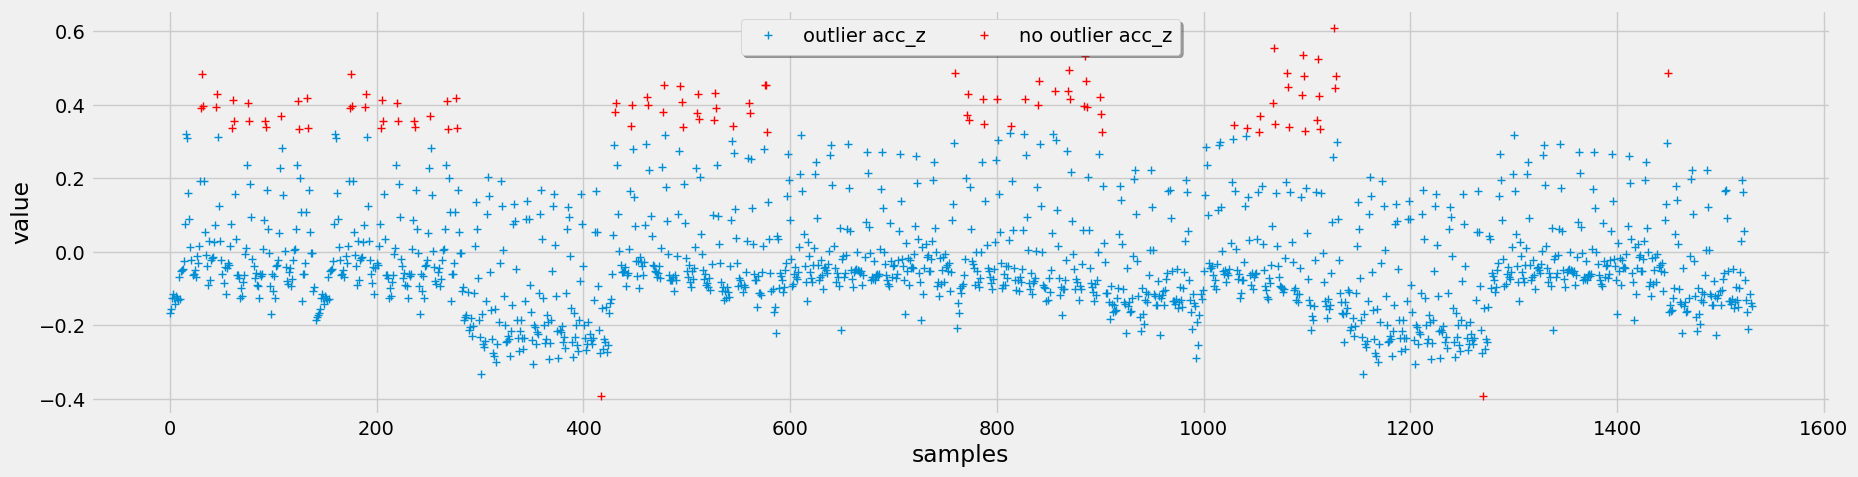

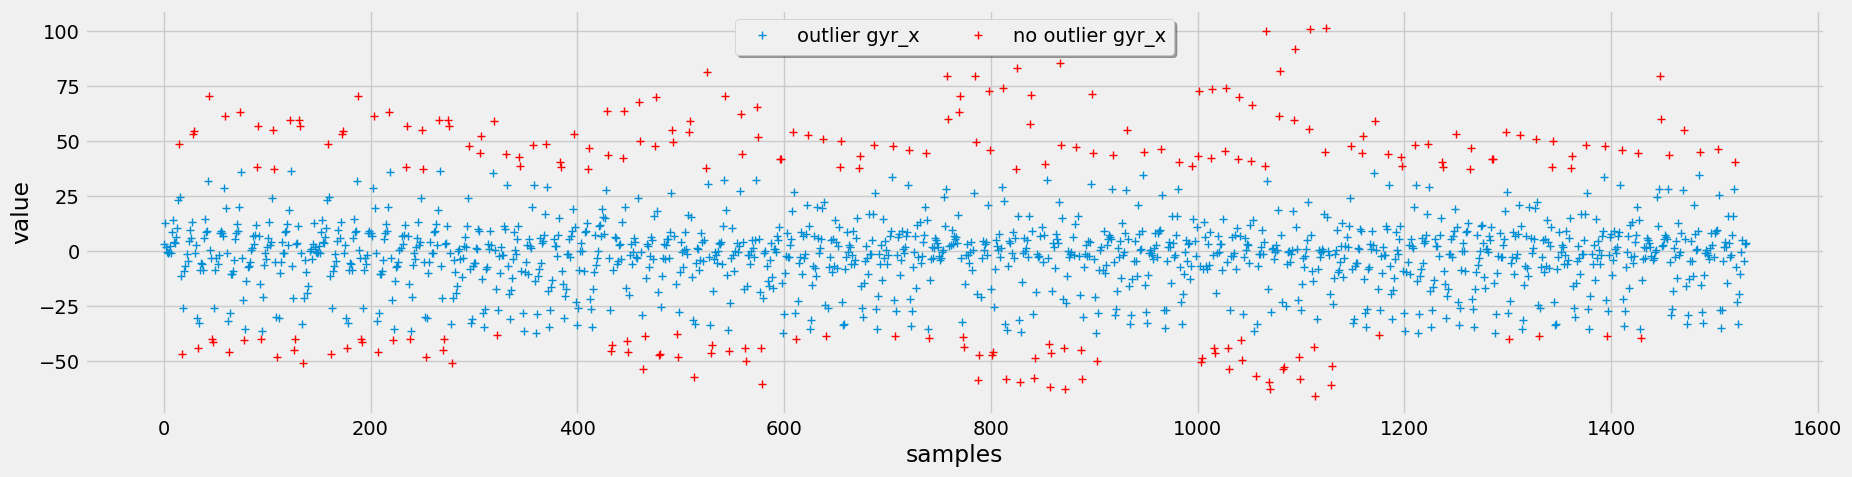

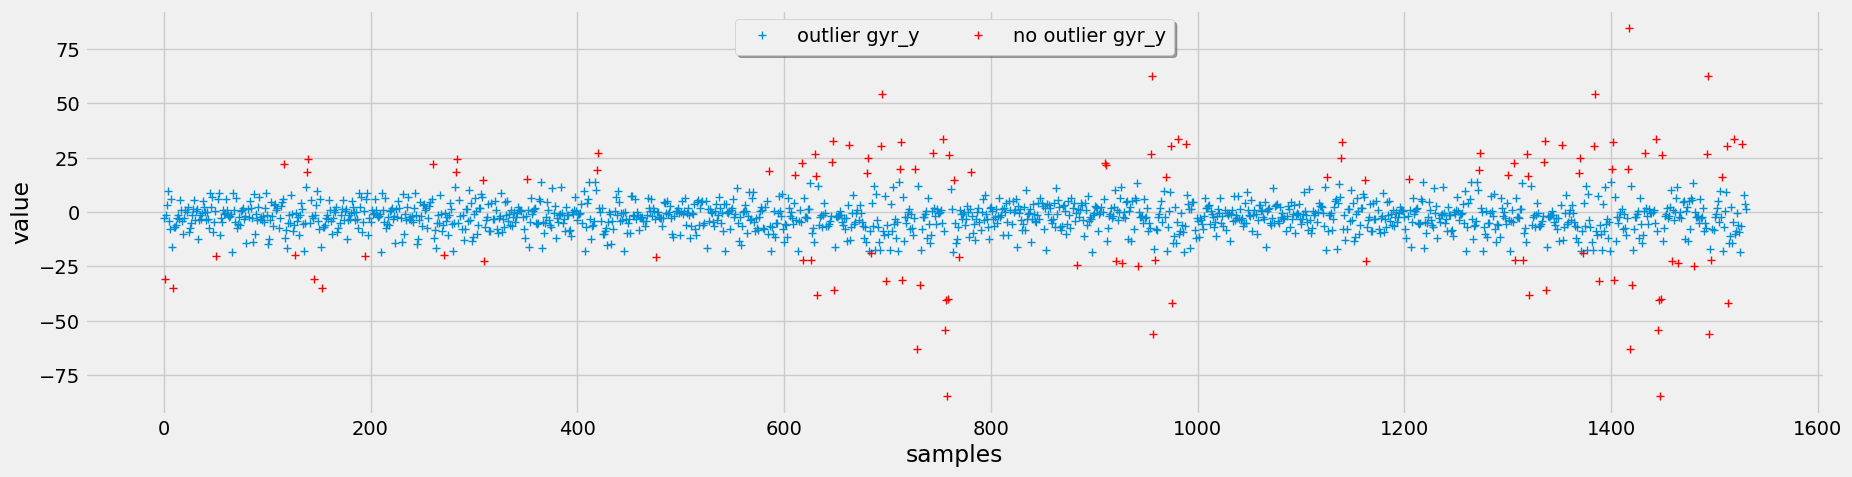

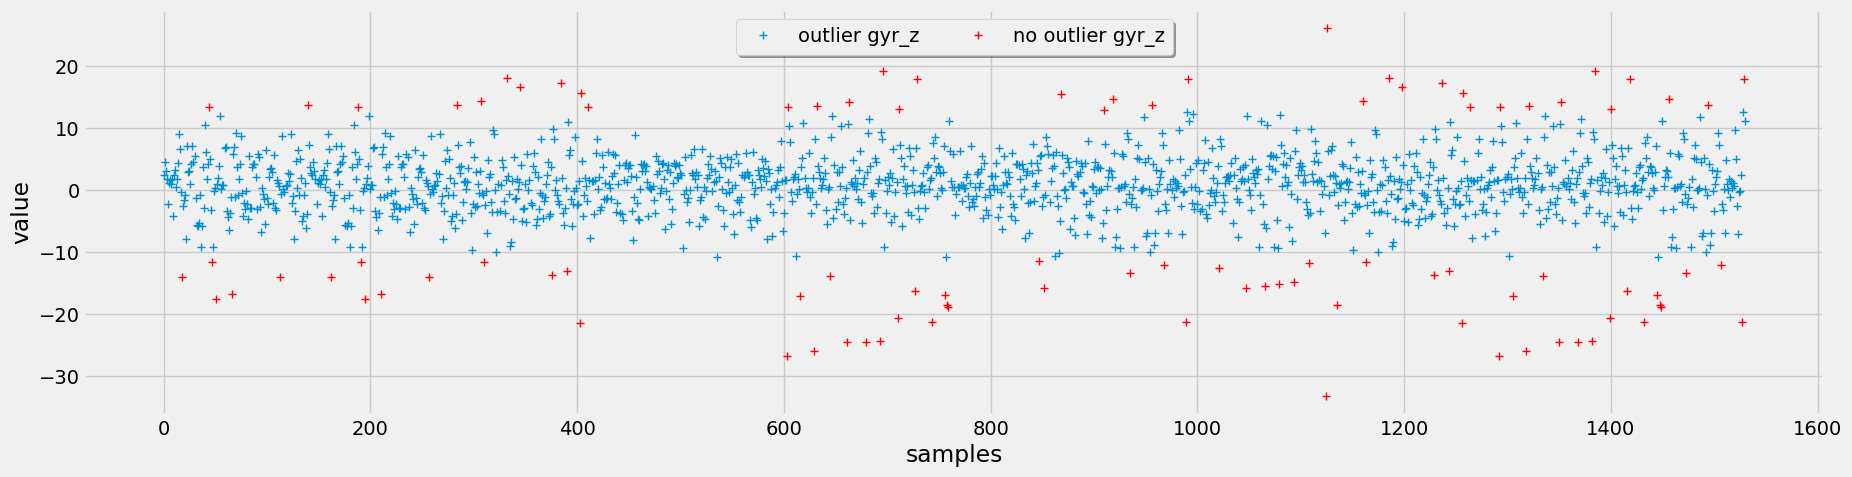

In [62]:
for col in outlier_columns:
    dataset = mark_outliers_iqr(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col+"_outlier", reset_index=True)

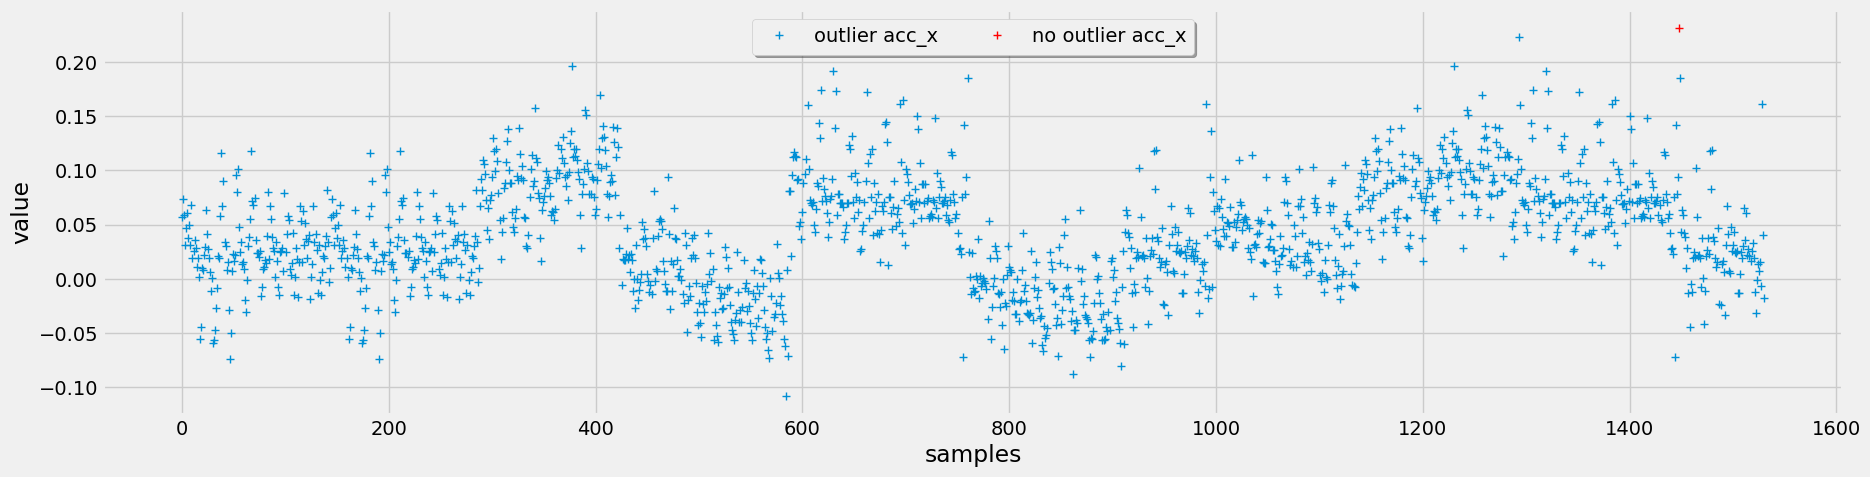

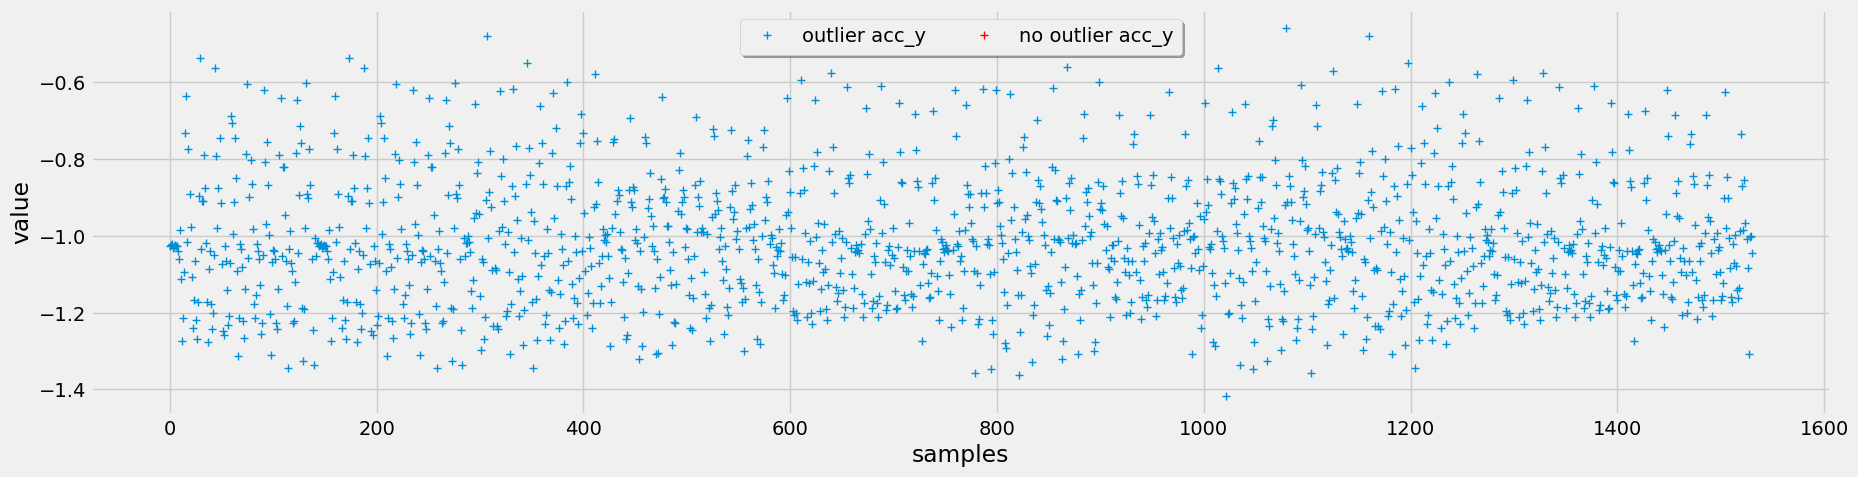

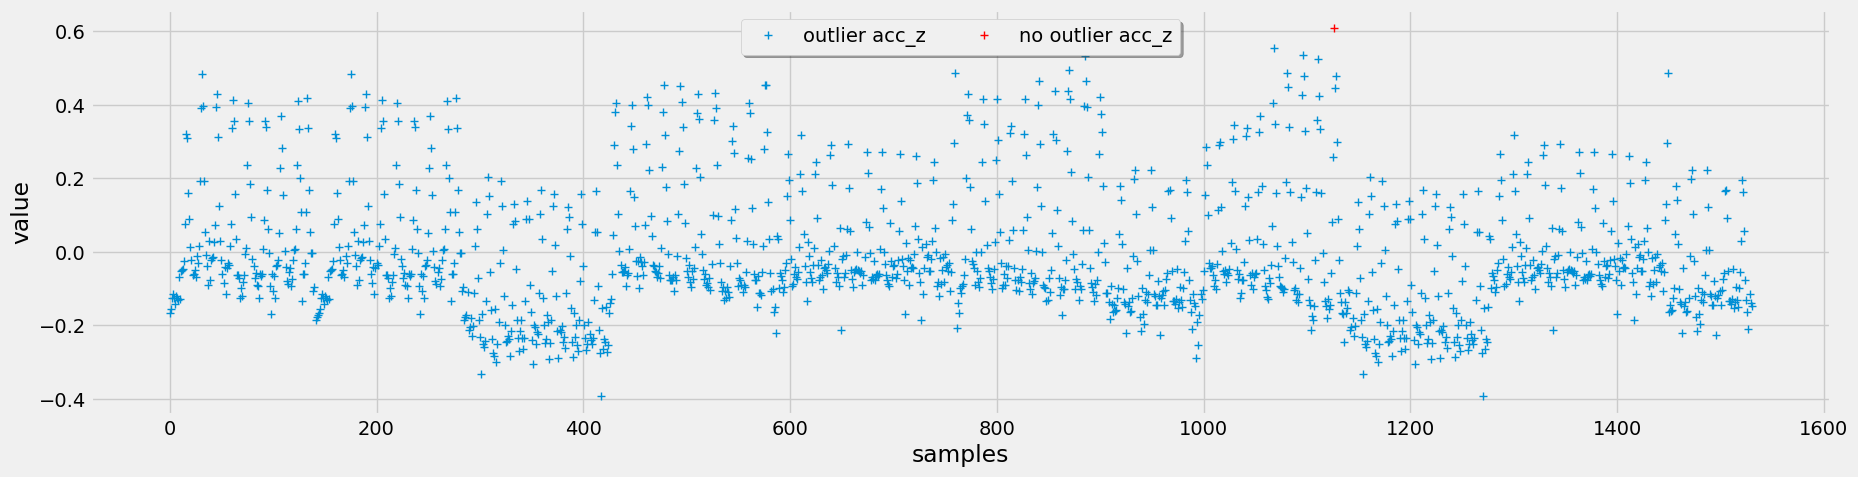

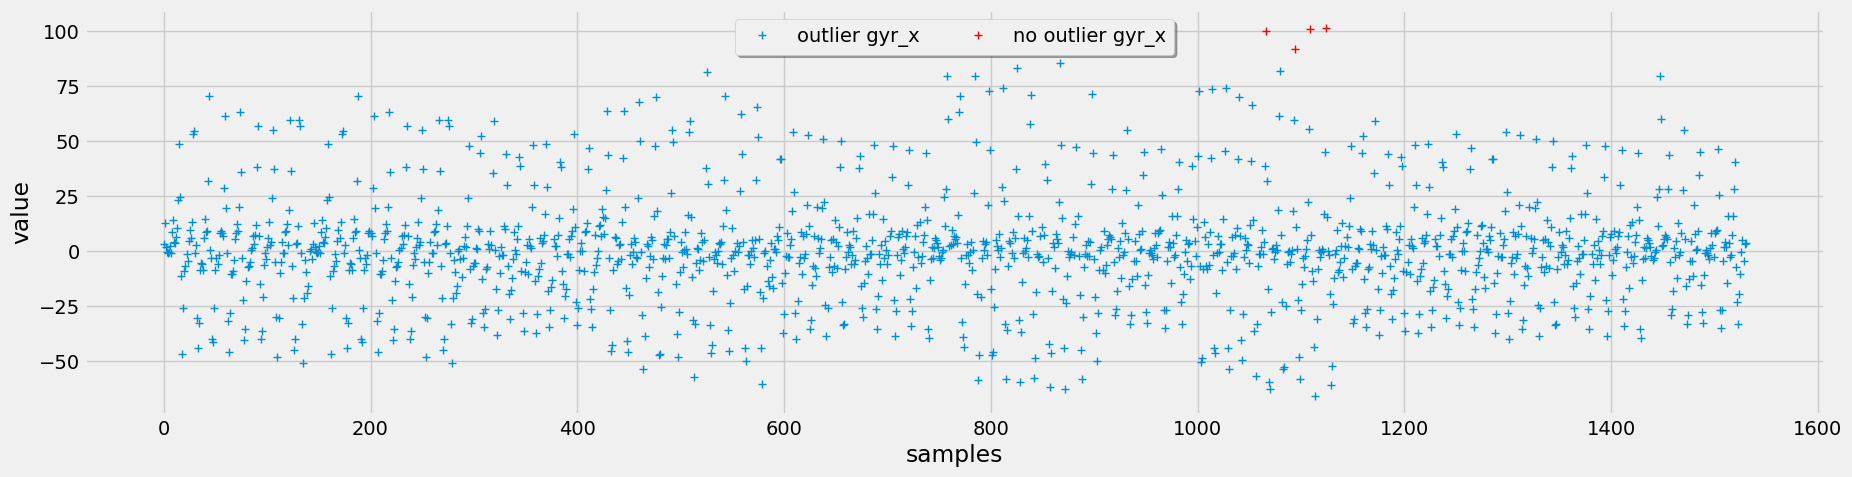

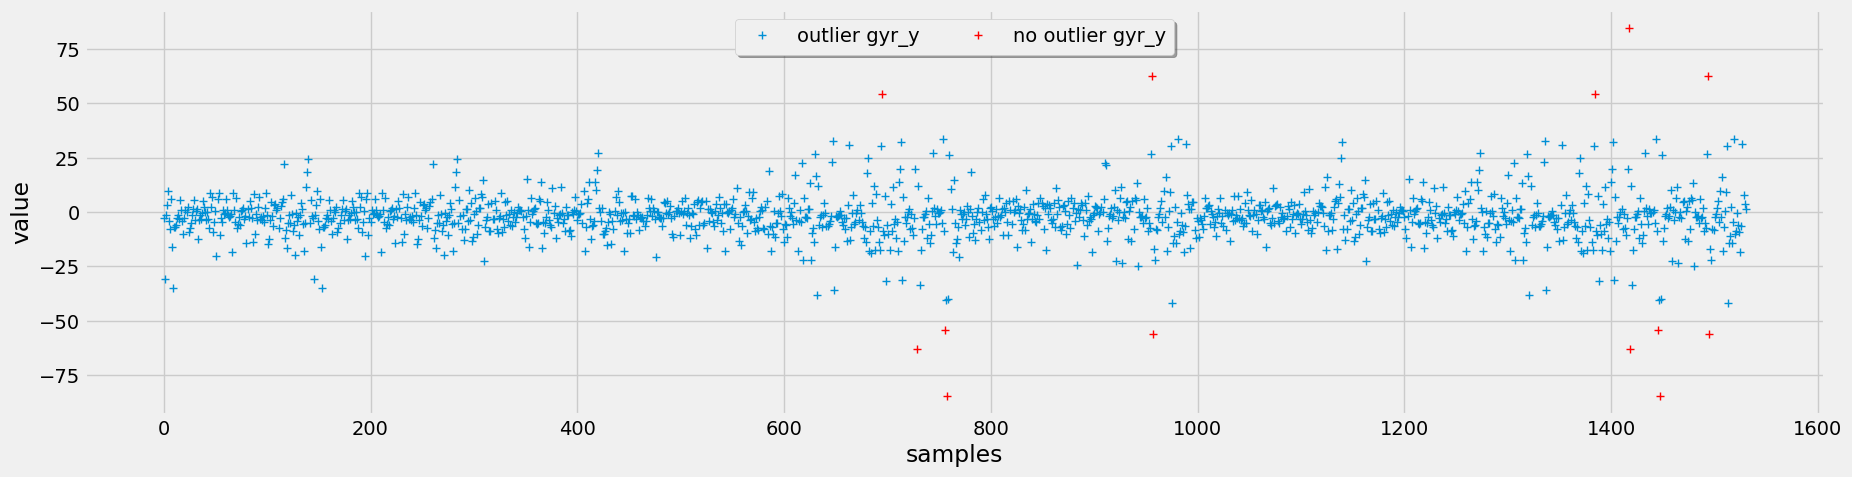

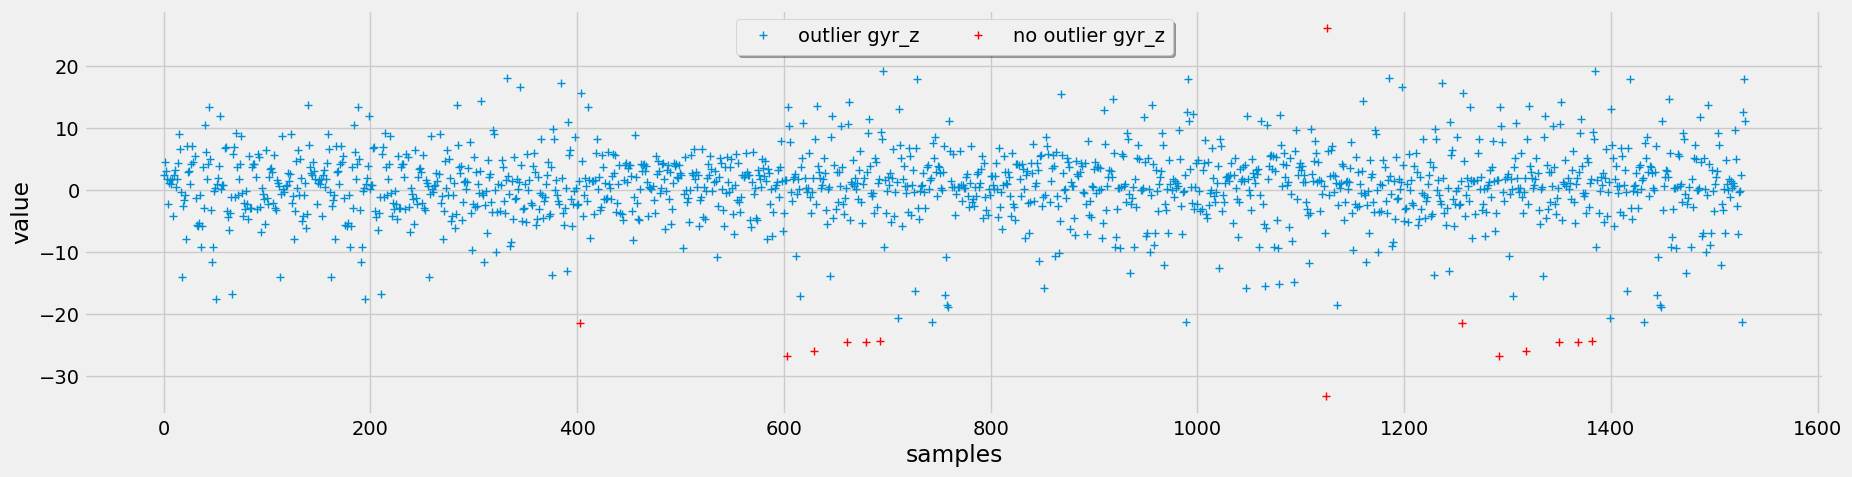

In [63]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col+"_outlier", reset_index=True)

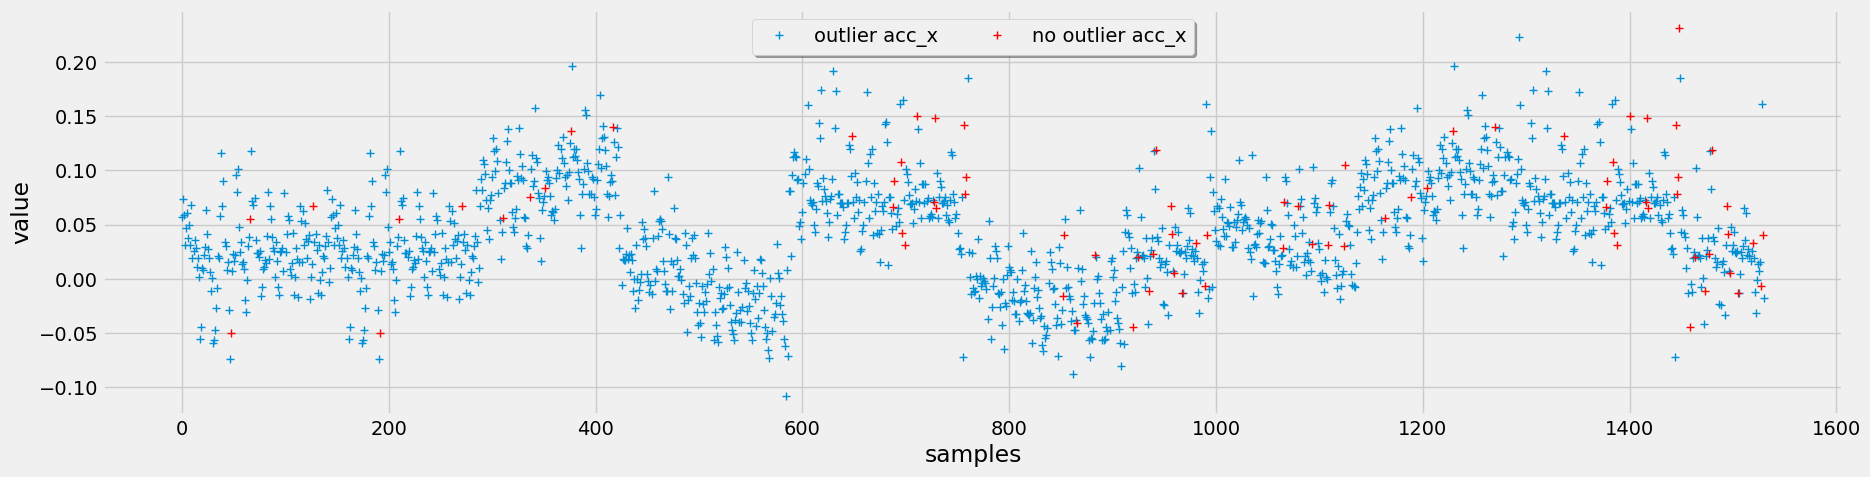

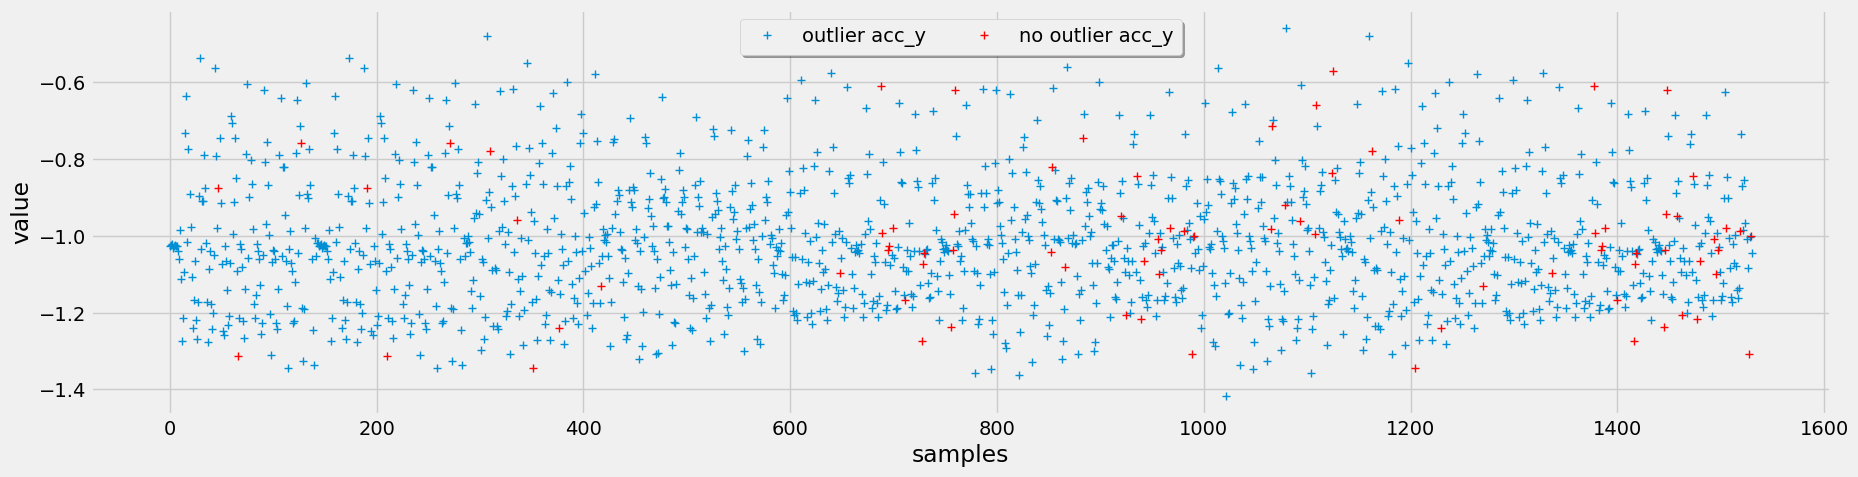

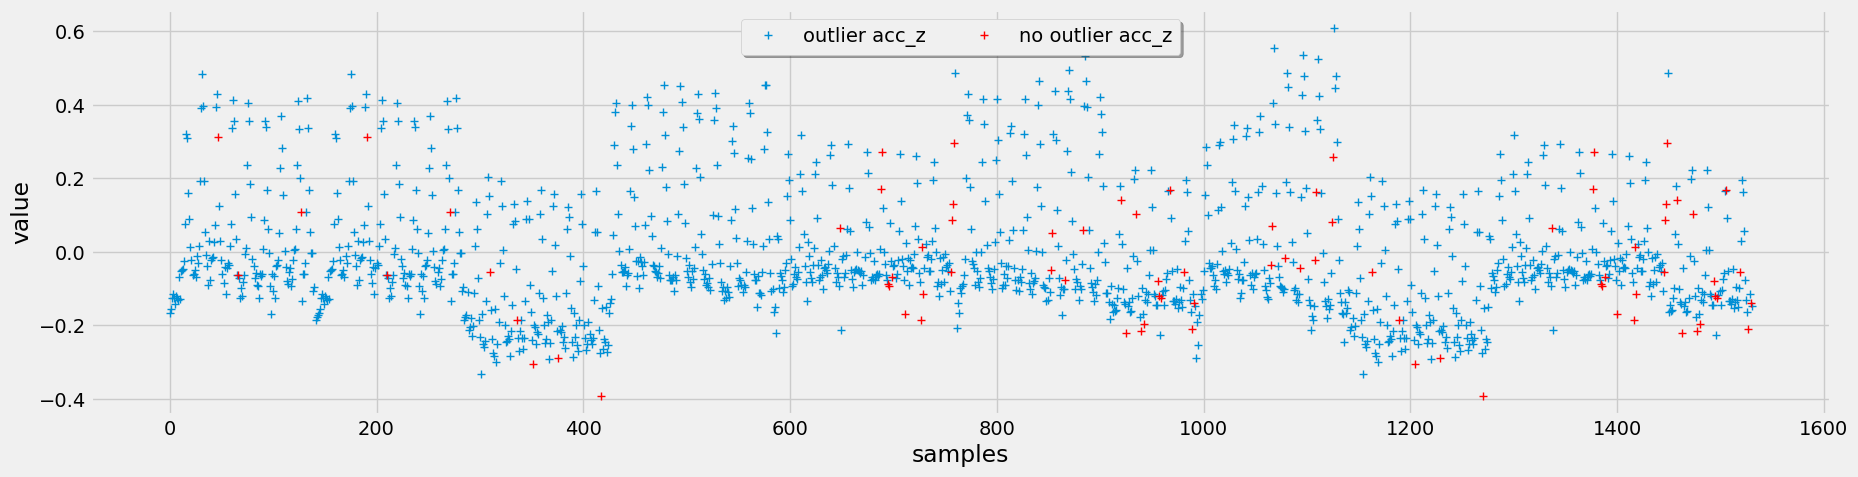

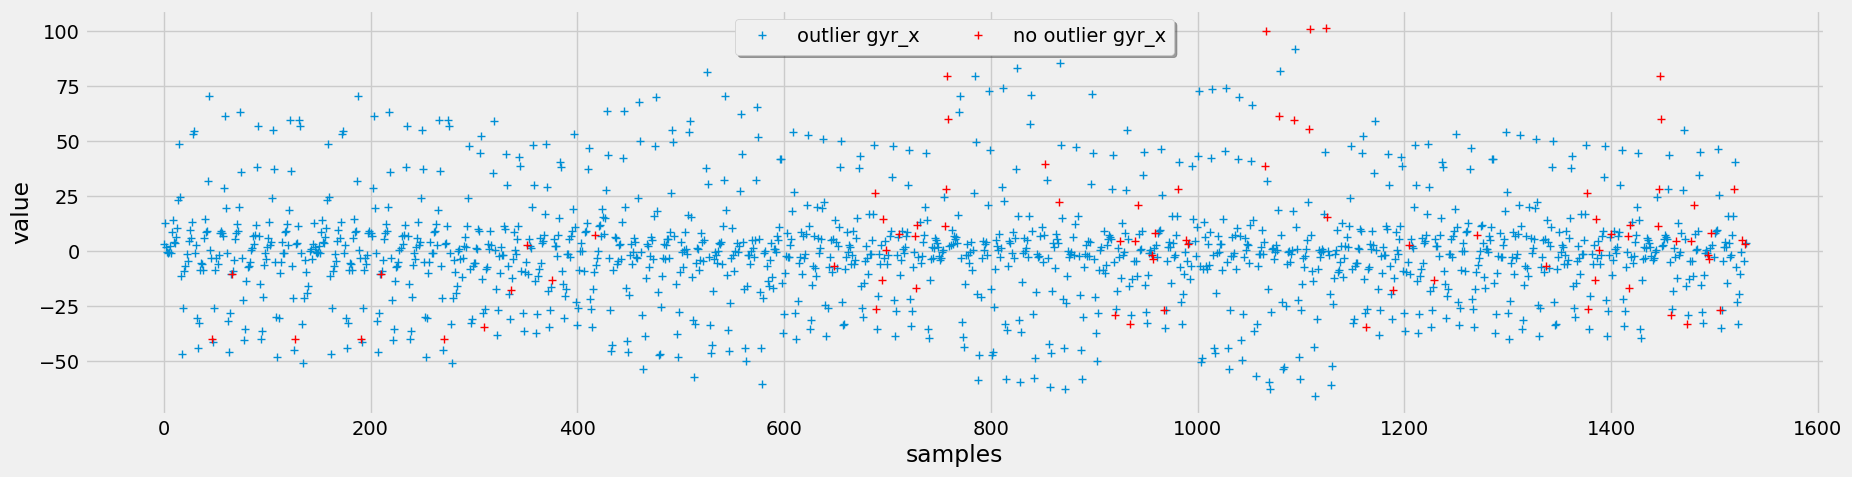

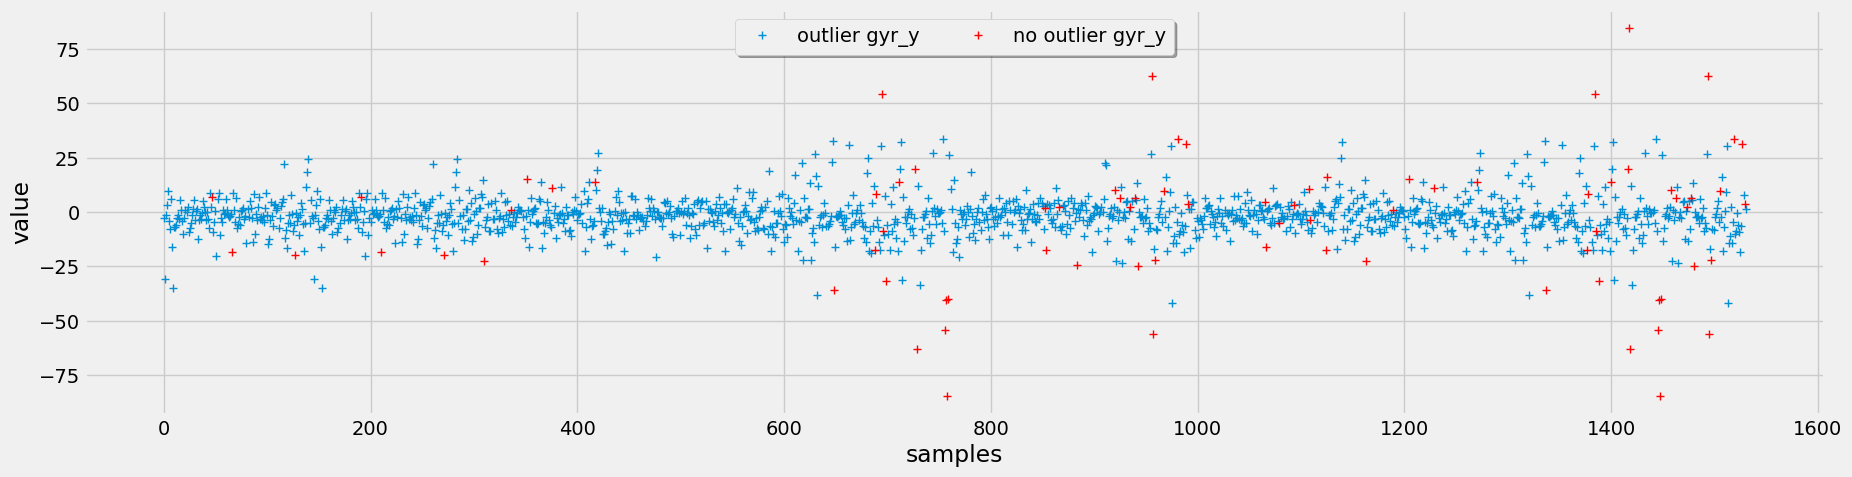

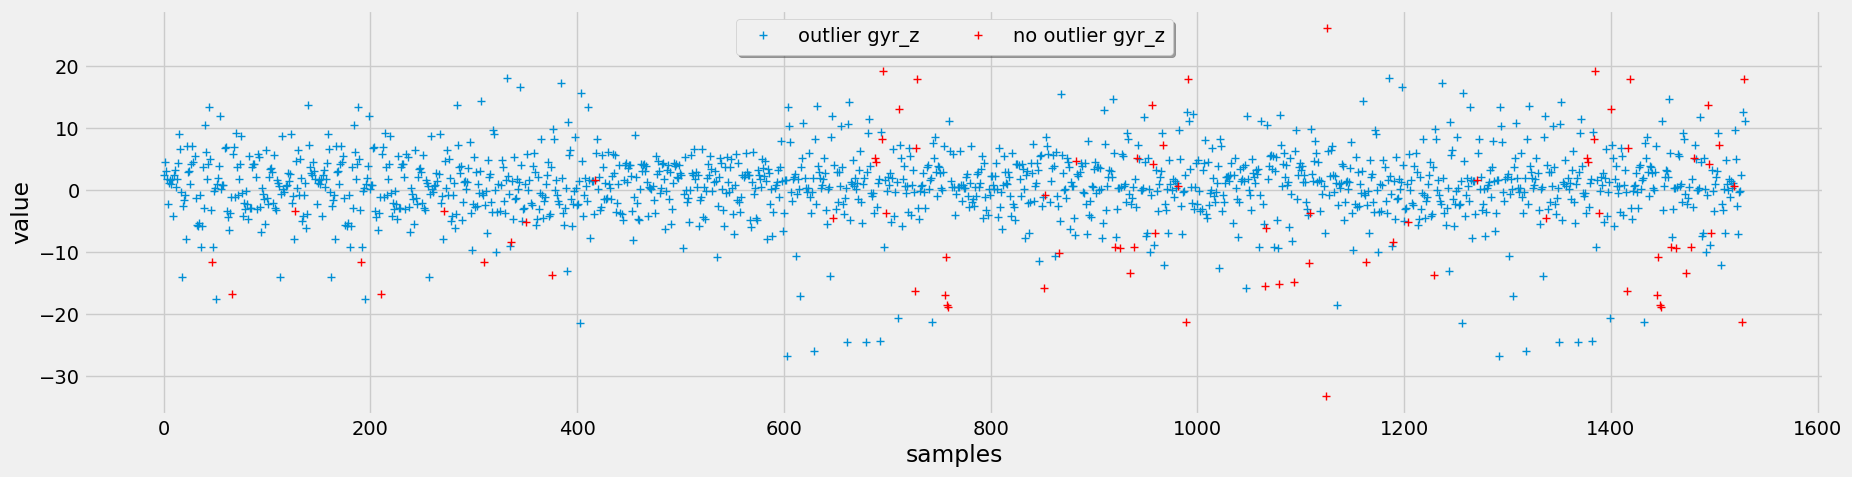

In [64]:
dataset, outliers, X_scores = mark_outliers_lof(df[df["label"] == label], outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True)

In [65]:
col = "gyr_z"
dataset = mark_outliers_chauvenet(df, col=col)
dataset[dataset["gyr_z_outlier"]]

acc_x     acc_y     acc_z     gyr_x     gyr_y  \
epoch (ms)                                                                  
2019-01-14 13:57:41.800 -0.137000  1.495500  0.217000   33.9146   14.6462   
2019-01-18 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-18 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-18 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-18 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-18 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-18 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-18 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-18 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-18 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-18 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-18 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-18 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-18 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-18 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-18 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-18 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-18 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-18 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-18 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-19 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-19 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-19 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-19 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-19 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-19 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-19 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-19 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-19 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-19 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-19 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-19 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-19 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-19 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-19 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-19 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-19 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-19 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-19 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-20 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-20 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-20 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-20 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-20 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-20 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-20 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-20 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-20 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-20 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-20 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-20 17:26:07.400 

In [66]:
dataset.loc[dataset["gyr_z_outlier"], "gyr_z"] = np.nan

In [67]:
dataset = mark_outliers_chauvenet(df[df["label"] == label], col)

In [68]:
dataset.loc[dataset[col + "_outlier"], col] = np.nan

In [70]:
outliers_removed_df = df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
        # Replace values marked as outlier with NaN
        dataset.loc[dataset[col + "_outlier"], col] = np.nan
        # Update the column in the original dataframe
        outliers_removed_df.loc[(outliers_removed_df["label"] == label), col] = dataset[col]
        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

Removed 0 from acc_x for bench
Removed 2 from acc_x for ohp
Removed 0 from acc_x for squat
Removed 2 from acc_x for dead
Removed 0 from acc_x for row
Removed 0 from acc_x for rest
Removed 5 from acc_y for bench
Removed 6 from acc_y for ohp
Removed 0 from acc_y for squat
Removed 0 from acc_y for dead
Removed 0 from acc_y for row
Removed 0 from acc_y for rest
Removed 3 from acc_z for bench
Removed 6 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 1 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 2 from gyr_x for bench
Removed 4 from gyr_x for ohp
Removed 1 from gyr_x for squat
Removed 6 from gyr_x for dead
Removed 0 from gyr_x for row
Removed 12 from gyr_x for rest
Removed 14 from gyr_y for bench
Removed 15 from gyr_y for ohp
Removed 9 from gyr_y for squat
Removed 14 from gyr_y for dead
Removed 10 from gyr_y for row
Removed 9 from gyr_y for rest
Removed 13 from gyr_z for bench
Removed 1 from gyr_z for ohp
Removed 12 from gyr_z for squat
Re

In [71]:
outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB
